In [1]:
## Initialize ##
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap
import scipy.special as scsp
import random as rand
from scipy.optimize import fsolve
import os
from tqdm import tqdm
from class_carbon_gambling import *
from colorsarr import colorsarr #For the colormap
colarr = colorsarr()
carr = colarr.carr
cd = os.getcwd()

def smoothen(list, nm = 10, lim=0):
    reslist = []
    meanlist = [k-nm//2 for k in range(nm)]
    for j in range(len(list)):
        #if abs(list[j] - list[j-1])<0.3:
        if j < len(list) - lim:
            lis = [list[min(max(0,j+k),len(list)-1)] for k in meanlist]
            #if list[j] >= list[j-1] or j<=5:
            reslist.append((sum(lis))/nm)
            #else:
            #    reslist.append(0.)
        else:
            reslist.append(list[j])
        #else:
        #    reslist.append(list[j])
    return reslist


china  MAE GDP / <GDP>: 0.1407824482329819 MAE Debt / <Debt>: 0.2267831809293518
china  Parameters: L = 1.025 , sigmaL =  0.023 , rho = 1.131 , sigmarho =  0.101 , W = 0.0886 , sigmaW = 0.086  , gamma = 1.096 , sigmagamma = 0.095


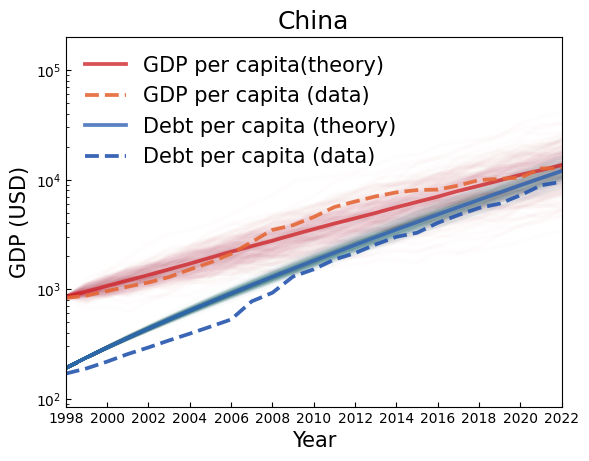

In [50]:
## GDP and Debt ##

country = "china" #Pick the country among US, china, denmark, france
duration = 25 #Duration in years
R2calc = False #If True, calculate R2, else calculate MAE

##DATA##
#For US
    #Between 1960 and 2022 #https://www.macrotrends.net/global-metrics/countries/usa/united-states/gdp-per-capita
    #Between 1960 and 2022 #https://www.macrotrends.net/global-metrics/countries/usa/united-states/debt-to-gdp-ratio
    #Between 1960 and 2022 #https://www.macrotrends.net/global-metrics/countries/usa/united-states/population
    # between 1980 and 2023 in millions USD

#For France
    #Between 1960 and 2022 #https://www.macrotrends.net/global-metrics/countries/fra/france/gdp-per-capita
    # Between 1998 and 2022 #https://www.macrotrends.net/global-metrics/countries/fra/france/debt-to-gdp-ratio
    # Between 1960 and 2022 #https://www.macrotrends.net/global-metrics/countries/fra/france/population
    # Between 1980 and 2022 #https://countryeconomy.com/deficit/france

#For Denmark
    #Between 1960 and 2022 #https://www.macrotrends.net/global-metrics/countries/dnk/denmark/gdp-per-capita
    #Between 1960 and 2022 #https://www.macrotrends.net/global-metrics/countries/dnk/denmark/population
    #Between 1960 and 2022 #https://www.macrotrends.net/global-metrics/countries/dnk/denmark/debt-to-gdp-ratio https://www.imf.org/external/datamapper/DEBT1@DEBT/GRC?zoom=GRC&highlight=GRC
    #From 1980 https://countryeconomy.com/deficit/denmark

#For China
    #between 1960 and 2022 #https://www.macrotrends.net/global-metrics/countries/chn/china/gdp-per-capita
    #between 1960 and 2022 #https://www.macrotrends.net/global-metrics/countries/chn/china/gdp-per-capita
    # Between 1984 and 2022 #https://www.macrotrends.net/global-metrics/countries/chn/china/debt-to-gdp-ratio
    # Between 1982 and 2022 #https://countryeconomy.com/national-debt/china



GDPpercapitalist = np.load(cd + '/data/GDPpercapita_'+country+'.npy') #Actual data for GDP
debtpercapitalist = np.load(cd + '/data/debtpercapita_'+country+'.npy') #Actual data for debt
poplist = np.load(cd + '/data/pop_'+country+'.npy') #Actual data for population
deficitpercapitalist = np.load(cd + '/data/deficitpercapita_'+country+'.npy') #Actual data for deficit
tflist=np.array(range(duration)) #Time frame list, from 0 to duration-1
firstyear = 1960 + GDPpercapitalist.size-duration #Starting year for the study

# Rescale all lists to have the same size
GDPpercapitalist = GDPpercapitalist[-duration:]
debtpercapitalist = debtpercapitalist[-duration:]
poplist = poplist[-duration:]
deficitpercapitalist = deficitpercapitalist[-duration:]
length=tflist.size-1

title = r'Minimal modeling of GDP and debt in ' + 'the US' if country == 'US' else str.upper(country[0]) + country[1:]
fig1 = plt.figure() 
ax1 = fig1.add_subplot(111)
# Create the colormap
clist = carr[:13].copy()
clist = [(0, clist[0]), (0.05, clist[1]), (0.1, clist[2]), (0.2, clist[3]), (0.32, clist[4]), (0.4, clist[5]), (0.5, clist[6]), (0.6, clist[7]), (0.65, clist[8]), (0.7, clist[9]), (0.75, clist[10]), (0.82, clist[11]), (1., clist[12])] #[(i*1/11., clist[i]) for i in range(len(clist))]
cmapphase = LinearSegmentedColormap.from_list('cmap', clist)

gratelist = [GDPpercapitalist[i] / GDPpercapitalist[i - 1] for i in range(1, len(GDPpercapitalist))] #Growth rate list, from 1 to duration-1
levlist = np.array([deficitpercapitalist[i] / GDPpercapitalist[i] + 1. for i in range(len(GDPpercapitalist))]) #Leverage list, from 1 to duration-1
rlist = np.array(gratelist) - 1. - deficitpercapitalist[1:] / GDPpercapitalist[1:] #Implicit growth rate list from 1 to duration-1
rholist = np.array([(debtpercapitalist[i+1] - (levlist[i]-1)*GDPpercapitalist[i])/debtpercapitalist[i] for i in range(len(rlist)-1)]) #Interest rate list from 1 to duration-2


##Initial conditions##
rep = 200
avgGDP = 0.
avglogGDP = 0.
avgdebt = 0.
avglogdebt = 0.
GDP0 = GDPpercapitalist[0] #Initial GDP per capita
L = np.mean(levlist) #Average leverage
rho = np.mean(rholist) #Average interest rate
meanW = np.mean(np.log(1.+rlist)) #Mean of the log of the implicit growth rate
sigW = np.std(np.log(1.+rlist)) #Standard deviation of the log of the implicit growth rate
meangamma, siggamma = np.mean(1.+rlist), np.std(1.+rlist) #Mean and standard deviation of the intrinsic growth rate
inidebt = debtpercapitalist[0] #Initial debt per capita

for i in range(rep):
    model = kelly_debt(5, L, GDP0, 100, rho, duration-1, gaussian=True, W = meanW, sig=sigW, borroweachstep=True, D0 = inidebt)
    model.evol()
    GDP = np.array(model.Clist) #GDP from stochastic model
    debt = np.array(model.Dlist) #Debt from stochastic model
    avgGDP += GDP
    avglogGDP += np.log(GDP)
    avgdebt += debt
    avglogdebt += np.log(debt)
    ax1.plot(firstyear+tflist, GDP, lw = 2.7, alpha = 2./rep, c=cmapphase(0.1))
    ax1.plot(firstyear+tflist, debt, lw = 2.7, alpha = 2./rep, c=cmapphase(0.67))

avgGDP = avgGDP/rep
avglogGDP = avglogGDP/rep
if R2calc:
    R2GDP = 1.-np.sum((GDPpercapitalist - avgGDP)**2)/np.sum((GDPpercapitalist - np.mean(GDPpercapitalist))**2)
else:
    MAEGDP = np.sum(np.abs(GDPpercapitalist - avgGDP))/len(GDPpercapitalist)
#ax1.text(firstyear+duration-7, GDP[-1]*6.5, r'$R^2={}$'.format(str(R2GDP)[:4]), fontsize=18, color=cmapphase(0.15))
ax1.plot(firstyear+tflist, avgGDP, lw = 2.7, alpha = 0.8, c=cmapphase(0.15), label=r'GDP per capita(theory)')
ax1.plot(firstyear+tflist, GDPpercapitalist, lw = 2.7, alpha = 0.9, ls='--', c=cmapphase(0.07), label=r'GDP per capita (data)') #[sum(GDPlist[:i]) for i in tflist]

avgdebt = avgdebt/rep
avglogdebt = avglogdebt/rep
if R2calc:
    R2debt = 1.-np.sum((debtpercapitalist - avgdebt)**2)/np.sum((debtpercapitalist - np.mean(debtpercapitalist))**2)
else:
    MAEdebt = np.sum(np.abs(debtpercapitalist - avgdebt))/len(debtpercapitalist)
#ax1.text(firstyear+duration-8, debt[-14], r'$R^2={}$'.format(str(R2debt)[:4]), fontsize=18, color=cmapphase(0.7))
ax1.plot(firstyear+tflist, avgdebt, lw = 2.7, alpha = 0.8, c=cmapphase(0.7), label=r'Debt per capita (theory)')
ax1.plot(firstyear+tflist, debtpercapitalist, lw = 2.7, alpha = 0.9, ls='--', c=cmapphase(0.73), label=r'Debt per capita (data)') #[sum(debtpercaplist[:i]) for i in tflist]

if R2calc:
    print(country, ' R2 GDP:', R2GDP, 'R2 Debt:', R2debt)
else:
    print(country, ' MAE GDP / <GDP>:', MAEGDP/np.mean(GDPpercapitalist), 'MAE Debt / <Debt>:', MAEdebt/np.mean(debtpercapitalist))
print(country, ' Parameters: L =', str(L)[:5], ', sigmaL = ', str(np.std(levlist))[:5], ', rho =', str(rho)[:5], ', sigmarho = ', str(np.std(rholist))[:5], ', W =', str(meanW)[:6], ', sigmaW =', str(sigW)[:5], ' , gamma =', str(meangamma)[:5], ', sigmagamma =', str(siggamma)[:5])

ax1.legend(fontsize=15, loc='best', frameon=False)
ax1.set_xlabel(r'Year', fontsize=15)
ax1.set_ylabel(r'GDP (USD)', fontsize=15)
ax1.margins(x=0)
ax1.set_yscale('log')
#ax1.set_xlim(firstyear+2, 2022)
ax1.set_xticks([firstyear+i for i in range(0, duration+1, 2)])
ax1.set_ylim(inidebt/2,2E5)
ax1.set_title(title, fontsize=18)
ax1.tick_params(direction='in', which='both')
fig1.savefig(cd + '/results/GDP_data'+country+'.pdf')

US R2 Emissions: 0.9960930969756511
china R2 Emissions: 0.9800079232006833
denmark R2 Emissions: 0.9825759666419148
france R2 Emissions: 0.9767930834145482


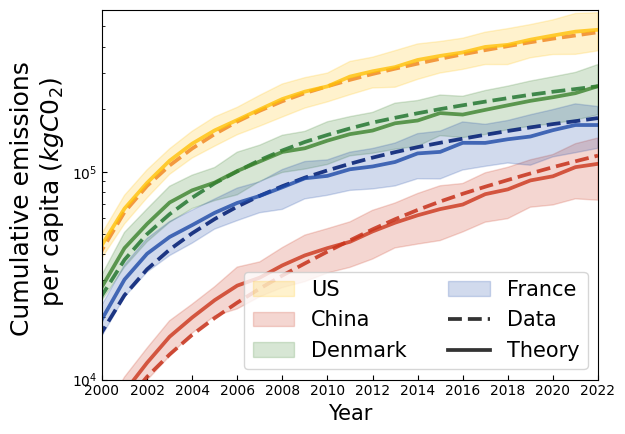

In [36]:
#all countries#
## Integrated emissions ##

temp = False
countries = ['US', 'china', 'denmark', 'france']
duration = 25 #Duration in years
R2calc = True #If True, calculate R2, else calculate MAE
territorial = False #If True, use territorial emissions, else use consumption-based emissions
territorialstr = 'territorial' if territorial else 'consumption-based'

title = r'Effect of debt on $CO_2$ emissions'
fig1 = plt.figure() 
ax1 = fig1.add_subplot(111)
clist = carr[:13].copy()
clist = [(0, clist[0]), (0.05, clist[1]), (0.1, clist[2]), (0.2, clist[3]), (0.32, clist[4]), (0.4, clist[5]), (0.5, clist[6]), (0.6, clist[7]), (0.65, clist[8]), (0.7, clist[9]), (0.75, clist[10]), (0.82, clist[11]), (1., clist[12])] #[(i*1/11., clist[i]) for i in range(len(clist))]
cmapphase = LinearSegmentedColormap.from_list('cmap', clist) #Create the colormap

for n, country in enumerate(countries):
    Emperyearlist = np.load(cd + '/data/Emperyearlist_'+country+'_'+territorialstr+'.npy') #Yearly emissions per capita data
    GDPpercapitalist = np.load(cd + '/data/GDPpercapita_'+country+'.npy') #GDP per capita data
    debtpercapitalist = np.load(cd + '/data/debtpercapita_'+country+'.npy') #Debt per capita data
    poplist = np.load(cd + '/data/pop_'+country+'.npy') #Population data
    deficitpercapitalist = np.load(cd + '/data/deficitpercapita_'+country+'.npy') #Deficit per capita data
    tflist=np.array(range(duration)) #Time frame list, from 0 to duration-1
    firstyear = 1960 + GDPpercapitalist.size-duration #Starting year for the study

    # Rescale all lists to have the same size
    Emperyearlist = Emperyearlist[-duration:]
    GDPpercapitalist = GDPpercapitalist[-duration:]
    debtpercapitalist = debtpercapitalist[-duration:]
    poplist = poplist[-duration:]
    deficitpercapitalist = deficitpercapitalist[-duration:]

    gratelist = [GDPpercapitalist[i] / GDPpercapitalist[i - 1] for i in range(1, len(GDPpercapitalist))] #Growth rate list, from 1 to duration-1
    levlist = deficitpercapitalist / GDPpercapitalist + 1. #Leverage list, from 1 to duration-1
    rlist = np.array(gratelist) - 1. - deficitpercapitalist[1:] / GDPpercapitalist[1:] #Implicit growth rate list from 1 to duration-1
    rholist = np.array([(debtpercapitalist[i+1] - (levlist[i]-1)*GDPpercapitalist[i])/debtpercapitalist[i] for i in range(len(rlist)-1)]) #Interest rate list from 1 to duration-2

    ##Initial conditions##
    GDP0 = GDPpercapitalist[0] #Initial GDP per capita
    L = np.mean(levlist) #Average leverage
    rho = np.mean(rholist) #Average interest rate
    meanW = np.mean(np.log(1.+rlist)) #Mean of the log of the implicit growth rate
    sigW = np.std(np.log(1.+rlist)) #Standard deviation of the log of the implicit growth rate
    inidebt = debtpercapitalist[0] #Initial debt per capita
    Emintensitylist = Emperyearlist/GDPpercapitalist #Emissions intensity list, from 0 to duration-1
    gamma, I0 = -(Emintensitylist[-1] - Emintensitylist[0])/Emintensitylist.size, Emintensitylist[0] #Linear parameters for the emissions intensity
    
    ax1.plot(firstyear+tflist, [sum(Emperyearlist[:i]) for i in tflist], lw = 2.7, alpha = 0.9, ls='--', c=cmapphase(n/4+0.05))#, label=r'$\mathcal{E}_{\text{per capita}}$ (data)' if n==0 else None)

    model = kelly_debt(5, L, GDP0, 100, rho, duration-1, gaussian=True, W = meanW, sig=sigW, borroweachstep=True, D0 = inidebt) #Stochastic model
    rep = 100 #Number of repetitions
    avgEm = 0.
    avgEmdiff = 0.
    stdsqr = 0.
    for i in range(rep):
        emissions = np.array([model.emissions(firstyear+tf, Emintensitylist, firstyear, predic = False)[0] for tf in tflist])
        emissionsdiff = np.array([emissions[tf+1] - emissions[tf] for tf in tflist[:-1]])
        emissionsdiff = np.array([(emissionsdiff[min(tf+1, len(tflist)-2)] + emissionsdiff[tf])/2. for tf in tflist[:-1]])
        avgEm += emissions #Update average
        avgEmdiff += emissionsdiff #Update standard deviation
        stdsqr += np.array([(emissions[tf] - avgEm[tf]/(i+(i==0)))**2 for tf in tflist])
    avgEm = avgEm/rep
    avgEmdiff = avgEmdiff/rep
    stdsqr = np.sqrt(stdsqr/rep)
    ax1.plot(firstyear+tflist, avgEm, lw = 2.7, alpha = 0.8, c=cmapphase(n/4))
    ax1.fill_between(firstyear+tflist, avgEm - stdsqr, avgEm + stdsqr, color=cmapphase(n/4), alpha=0.2, label=str.upper(country[0]) + country[1:]) #Standard deviation from stochasticity

    if R2calc:
        R2em = 1. - np.sum((np.array([sum(Emperyearlist[:i]) for i in tflist]) - avgEm)**2)/np.sum((np.array([sum(Emperyearlist[:i]) for i in tflist]) - np.mean(np.array([sum(Emperyearlist[:i]) for i in tflist])))**2)
        print(country, 'R2 Emissions:', R2em)
    else:
        MAEem = np.sum(np.abs(np.array([sum(Emperyearlist[:i]) for i in tflist]) - avgEm))/len(Emperyearlist)
        print(country, 'MAE Emissions / <Emissions>:', MAEem/np.mean(np.array([sum(Emperyearlist[:i]) for i in tflist])))
    

ylimmin, ylimmax = 1E4, 6E5
ax1.plot(0, 0, lw = 2.7, ls='--', alpha = 0.8, c='black', label = 'Data')
ax1.plot(0, 0, lw = 2.7, alpha = 0.8, c='black', label = 'Theory')
ax1.set_xlim(firstyear + 2, 2022)
ax1.set_ylim(ylimmin, ylimmax)
if temp:
    ax2 = ax1.twinx()
    ax2.yaxis.tick_right()
    ax2.yaxis.set_tick_params(direction='in', which='both')
    ax2.set_ylabel(r'$\Delta T$ ($^{\circ}$C)', fontsize=15, labelpad=0)
    worldpop = 8E9
    ax2.set_ylim(ylimmin*1.6*1E-5, ylimmax*1.6*1E-15*worldpop)

ax1.legend(fontsize=15, loc='lower right', ncols = 2)
ax1.set_xlabel(r'Year', fontsize=15)
ax1.set_ylabel(r'Cumulative emissions ' + '\n' +r' per capita ($kgC0_2$)', fontsize=18)
ax1.margins(x=0)
ax1.set_yscale('log')
ax1.set_xticks([firstyear+i for i in range(2, duration+1, 2)])
ax1.tick_params(direction='in', which='both')
fig1.savefig(cd + '/results/emissions_data_all_'+territorialstr+'.pdf')

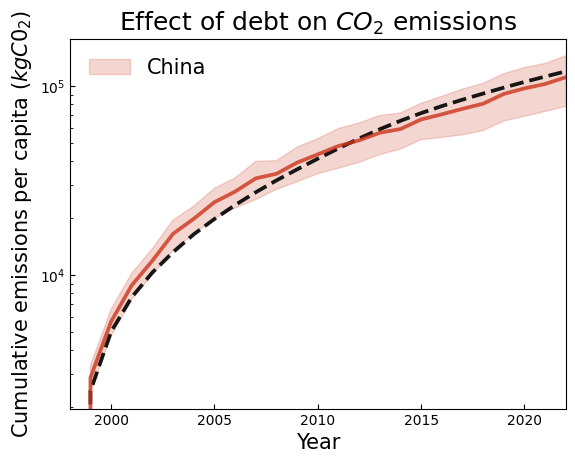

In [ ]:
## Integrated emissions for single countries##

country = "china" #Pick the country among US, china, denmark, france
duration = 25 #Duration in years
territorial = False #If True, use territorial emissions, else use consumption-based emissions
territorialstr = 'territorial' if territorial else 'consumption-based'

#Emperyearlist = np.load(cd + '/data/Emperyearlist_'+country+'.npy') #Yearly emissions per capita data
GDPpercapitalist = np.load(cd + '/data/GDPpercapita_'+country+'.npy') #GDP per capita data
debtpercapitalist = np.load(cd + '/data/debtpercapita_'+country+'.npy') #Debt per capita data
poplist = np.load(cd + '/data/pop_'+country+'.npy') #Population data
deficitpercapitalist = np.load(cd + '/data/deficitpercapita_'+country+'.npy') #Deficit per capita data
tflist=np.array(range(duration)) #Time frame list, from 0 to duration-1
firstyear = 1960 + GDPpercapitalist.size-duration #Starting year for the study
Emperyearlist = np.load(cd + '/data/Emperyearlist_'+country+'_'+territorialstr+'.npy') #Yearly emissions per capita data


clist = carr[:13].copy()
clist = [(0, clist[0]), (0.05, clist[1]), (0.1, clist[2]), (0.2, clist[3]), (0.32, clist[4]), (0.4, clist[5]), (0.5, clist[6]), (0.6, clist[7]), (0.65, clist[8]), (0.7, clist[9]), (0.75, clist[10]), (0.82, clist[11]), (1., clist[12])] #[(i*1/11., clist[i]) for i in range(len(clist))]
cmapphase = LinearSegmentedColormap.from_list('cmap', clist) #Create the colormap

# Rescale all lists to have the same size
Emperyearlist = Emperyearlist[-duration:]
GDPpercapitalist = GDPpercapitalist[-duration:]
debtpercapitalist = debtpercapitalist[-duration:]
poplist = poplist[-duration:]
deficitpercapitalist = deficitpercapitalist[-duration:]

gratelist = [GDPpercapitalist[i] / GDPpercapitalist[i - 1] for i in range(1, len(GDPpercapitalist))] #Growth rate list, from 1 to duration-1
levlist = deficitpercapitalist / GDPpercapitalist + 1. #Leverage list, from 1 to duration-1
rlist = np.array(gratelist) - 1. - deficitpercapitalist[1:] / GDPpercapitalist[1:] #Implicit growth rate list from 1 to duration-1
rholist = np.array([(debtpercapitalist[i+1] - (levlist[i]-1)*GDPpercapitalist[i])/debtpercapitalist[i] for i in range(len(rlist)-1)]) #Interest rate list from 1 to duration-2

##Initial conditions##
GDP0 = GDPpercapitalist[0] #Initial GDP per capita
L = np.mean(levlist) #Average leverage
rho = np.mean(rholist) #Average interest rate
meanW = np.mean(np.log(1.+rlist)) #Mean of the log of the implicit growth rate
sigW = np.std(np.log(1.+rlist)) #Standard deviation of the log of the implicit growth rate
inidebt = debtpercapitalist[0] #Initial debt per capita
Emintensitylist = Emperyearlist/GDPpercapitalist #Emissions intensity list, from 0 to duration-1
gamma, I0 = -(Emintensitylist[-1] - Emintensitylist[0])/Emintensitylist.size, Emintensitylist[0] #Linear parameters for the emissions intensity

fig1 = plt.figure() 
ax1 = fig1.add_subplot(111)

ax1.plot(firstyear+tflist, [sum(Emperyearlist[:i]) for i in tflist], lw = 2.7, alpha = 0.9, ls='--', c='black')#, label=r'$\mathcal{E}_{\text{per capita}}$ (data)' if n==0 else None)

model = kelly_debt(5, L, GDP0, 100, rho, duration-1, gaussian=True, W = meanW, sig=sigW, borroweachstep=True, D0 = inidebt) #Stochastic model
rep = 100 #Number of repetitions
avgEm = 0.
avgEmdiff = 0.
stdsqr = 0.
for i in range(rep):
    emissions = np.array([model.emissions(firstyear+tf, Emintensitylist, firstyear, predic = False)[0] for tf in tflist])
    emissionsdiff = np.array([emissions[tf+1] - emissions[tf] for tf in tflist[:-1]])
    emissionsdiff = np.array([(emissionsdiff[min(tf+1, len(tflist)-2)] + emissionsdiff[tf])/2. for tf in tflist[:-1]])
    avgEm += emissions #Update average
    avgEmdiff += emissionsdiff #Update standard deviation
    stdsqr += np.array([(emissions[tf] - avgEm[tf]/(i+(i==0)))**2 for tf in tflist])
avgEm = avgEm/rep
avgEmdiff = avgEmdiff/rep
stdsqr = np.sqrt(stdsqr/rep)
ax1.plot(firstyear+tflist, avgEm, lw = 2.7, alpha = 0.8, c=cmapphase(1/4))
ax1.fill_between(firstyear+tflist, avgEm - stdsqr, avgEm + stdsqr, color=cmapphase(1/4), alpha=0.2, label=str.upper(country[0]) + country[1:]) #Standard deviation from stochasticity


ax1.set_xlim(firstyear,2022)
ax1.legend(fontsize=15, loc='upper left', frameon=False)
ax1.set_xlabel(r'Year', fontsize=15)
ax1.set_ylabel(r'Cumulative emissions ' + '\n' +r' per capita ($kgC0_2$)', fontsize=18)
ax1.margins(x=0)
ax1.set_yscale('log')
ax1.set_title(title, fontsize=18)
ax1.tick_params(direction='in', which='both')
fig1.savefig(cd + '/results/emissions_data'+country+'.pdf')

/var/folders/88/nhwhjjhs73j3_587yk930r480000gp/T/ipykernel_6611/11107091.py:50: RuntimeWarning: invalid value encountered in scalar divide
  datapdIlist = np.array([np.sum(Emperyearlist[:tau])/(np.sum(GDPpercapitalist[:tau])) for tau in tflist]) #Data for path dependent intensity list from 0 to duration-1
/var/folders/88/nhwhjjhs73j3_587yk930r480000gp/T/ipykernel_6611/11107091.py:65: RuntimeWarning: invalid value encountered in scalar divide
  pdIlist = np.array([emissionscum[tau]/GDPcum[tau] for tau in range(np.size(em,0) )]) #Path dependent intensity list


US R2 path dependent intensity: 0.9377702480642053
china R2 path dependent intensity: 0.9852210037239506
denmark R2 path dependent intensity: 0.981122572019097
france R2 path dependent intensity: 0.9822190090038542


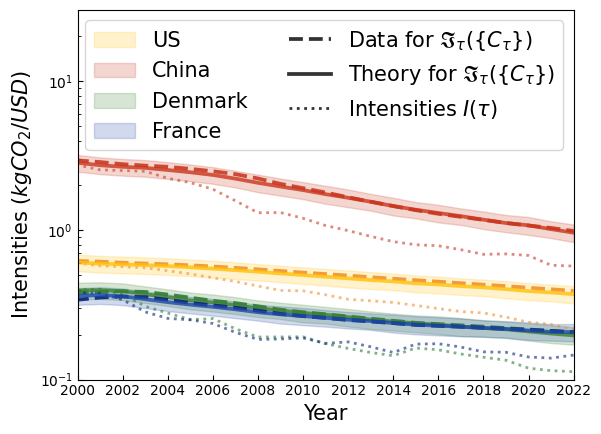

In [37]:
## Lock-in effect and path dependent intenbsities##

R2calc = True #If True, calculate R2, else calculate MAE
territorial = False #If True, use territorial emissions, else use consumption-based emissions
territorialstr = 'territorial' if territorial else 'consumption-based'

fig1 = plt.figure() 
ax1 = fig1.add_subplot(111)
clist = carr[:13].copy()
clist = [(0, clist[0]), (0.05, clist[1]), (0.1, clist[2]), (0.2, clist[3]), (0.32, clist[4]), (0.4, clist[5]), (0.5, clist[6]), (0.6, clist[7]), (0.65, clist[8]), (0.7, clist[9]), (0.75, clist[10]), (0.82, clist[11]), (1., clist[12])] #[(i*1/11., clist[i]) for i in range(len(clist))]
cmapphase = LinearSegmentedColormap.from_list('cmap', clist) #Create colormap

duration = 25 #Duration in years
firstyear = 2022 - duration #Starting year for the study
tflist=np.array(range(duration)) #Time frame list, from 0 to duration-1

temp, logscale = True, True #True to show temperature variation on right axis, True to use a logscale for y axis
countries = ['US', 'china', 'denmark', 'france'] #Different countries to study

for n, country in enumerate(countries):
    Emperyearlist = np.load(cd + '/data/Emperyearlist_'+country+'_'+territorialstr+'.npy') #Yearly emissions per capita data
    GDPpercapitalist = np.load(cd + '/data/GDPpercapita_'+country+'.npy') #GDP per capita data
    debtpercapitalist = np.load(cd + '/data/debtpercapita_'+country+'.npy') #Debt per capita data
    poplist = np.load(cd + '/data/pop_'+country+'.npy') #Population data
    deficitpercapitalist = np.load(cd + '/data/deficitpercapita_'+country+'.npy') #Deficit per capita data
    tflist=np.array(range(duration)) #Time frame list, from 0 to duration-1
    firstyear = 1960 + GDPpercapitalist.size-duration #Starting year for the study

    # Rescale all lists to have the same size
    Emperyearlist = Emperyearlist[-duration:]
    GDPpercapitalist = GDPpercapitalist[-duration:]
    debtpercapitalist = debtpercapitalist[-duration:]
    poplist = poplist[-duration:]
    deficitpercapitalist = deficitpercapitalist[-duration:]

    gratelist = [GDPpercapitalist[i] / GDPpercapitalist[i - 1] for i in range(1, len(GDPpercapitalist))] #Growth rate list, from 1 to duration-1
    levlist = deficitpercapitalist / GDPpercapitalist + 1. #Leverage list, from 1 to duration-1
    rlist = np.array(gratelist) - 1. - deficitpercapitalist[1:] / GDPpercapitalist[1:] #Implicit growth rate list from 1 to duration-1
    rholist = np.array([(debtpercapitalist[i+1] - (levlist[i]-1)*GDPpercapitalist[i])/debtpercapitalist[i] for i in range(len(rlist)-1)]) #Interest rate list from 1 to duration-2

    ##Initial conditions##
    GDP0 = GDPpercapitalist[0] #Initial GDP per capita
    L = np.mean(levlist) #Average leverage
    rho = np.mean(rholist) #Average interest rate
    meanW = np.mean(np.log(1.+rlist)) #Mean of the log of the implicit growth rate
    sigW = np.std(np.log(1.+rlist)) #Standard deviation of the log of the implicit growth rate
    inidebt = debtpercapitalist[0] #Initial debt per capita
    Emintensitylist = Emperyearlist/GDPpercapitalist #Emissions intensity list, from 0 to duration-1

    datapdIlist = np.array([np.sum(Emperyearlist[:tau])/(np.sum(GDPpercapitalist[:tau])) for tau in tflist]) #Data for path dependent intensity list from 0 to duration-1
    ax1.plot(firstyear + tflist, datapdIlist, lw = 2.7, alpha = 0.9, ls='--', c=cmapphase(n/4+0.05))
    ax1.plot(firstyear + tflist, Emintensitylist, lw = 2., alpha = 0.6, ls=':', c=cmapphase(n/4+0.05))
    
    model = kelly_debt(5, L, GDP0, 100, rho, duration-1, gaussian=True, W = meanW, sig=sigW, borroweachstep=True, D0 = inidebt) #Stochastic model
    rep = 100 #Number of repetitions
    avgpdI = 0. #Initiate average path dependent intensity
    em = np.array([model.emissions(firstyear+tf, Emintensitylist, firstyear, predic = False) for tf in tflist])
    emissionscum = np.array([em[tau][0] for tau in range(np.size(em,0) )]) #Cumulated emissions
    GDPcum = np.array([em[tau][1] for tau in range(np.size(em,0) )]) #Cumulated GDP
    stdsqr = 0. #Initiate standard deviation for path dependent intensity
    for i in range(rep):
        em = np.array([model.emissions(firstyear+tf, Emintensitylist, firstyear, predic = False) for tf in tflist])
        emissionscum = np.array([em[tau][0] for tau in range(np.size(em,0) )]) #Cumulated emissions
        GDPcum = np.array([em[tau][1] for tau in range(np.size(em,0) )]) #Cumulated GDP
        pdIlist = np.array([emissionscum[tau]/GDPcum[tau] for tau in range(np.size(em,0) )]) #Path dependent intensity list
        avgpdI += pdIlist #Update average
        stdsqr += np.array([(pdIlist[tau] - avgpdI[tau]/(i+(i==0)))**2 for tau in range(np.size(pdIlist))]) #Update standard deviation
    avgpdI = avgpdI/rep
    stdsqr = np.sqrt(stdsqr/rep)
    if R2calc:
        R2pdI = 1.-np.sum((datapdIlist[1:] - avgpdI[1:])**2)/np.sum((datapdIlist[1:] - np.mean(datapdIlist[1:]))**2)
        print(country, 'R2 path dependent intensity:', R2pdI)
    else:
        MAEpdI = np.sum(np.abs(datapdIlist[1:] - avgpdI[1:]))/len(datapdIlist[1:])
        print(country, 'MAE path dependent intensity / <I>:', MAEpdI/np.mean(datapdIlist[1:]))
    ax1.plot(firstyear+tflist, avgpdI, lw = 2.7, alpha = 0.8, c=cmapphase(n/4))
    ax1.fill_between(firstyear+tflist, avgpdI - stdsqr, avgpdI + stdsqr, color=cmapphase(n/4), alpha=0.2, label=str.upper(country[0]) + country[1:])

ylimmin, ylimmax = 1E-1, 3E1
ax1.plot(0, 0, lw = 2.7, ls='--', alpha = 0.8, c='black', label = r'Data for $\mathfrak{I}_{\tau}\left(\{C_{\tau}\}\right)$')
ax1.plot(0, 0, lw = 2.7, alpha = 0.8, c='black', label = r'Theory for $\mathfrak{I}_{\tau}\left(\{C_{\tau}\}\right)$')
ax1.plot(0, 0, lw = 2., ls = ':', alpha = 0.8, c='black', label = r'Intensities $I(\tau)$')
ax1.set_xlim(firstyear + 2, 2022)
ax1.set_ylim(ylimmin, ylimmax)

title = 'Path-dependent intensities'
ax1.legend(fontsize=15, loc='upper right', ncols = 2)
ax1.set_xlabel(r'Year', fontsize=15)
ax1.set_ylabel(r'Intensities ($kgCO_2/USD$)', fontsize=15)
ax1.margins(x=0)
ax1.set_yscale('log')
ax1.set_xticks([firstyear+i for i in range(2, duration+1, 2)])
ax1.tick_params(direction='in', which='both')

fig1.savefig(cd + '/results/lockin_pathdepint_all_'+territorialstr+'.pdf')

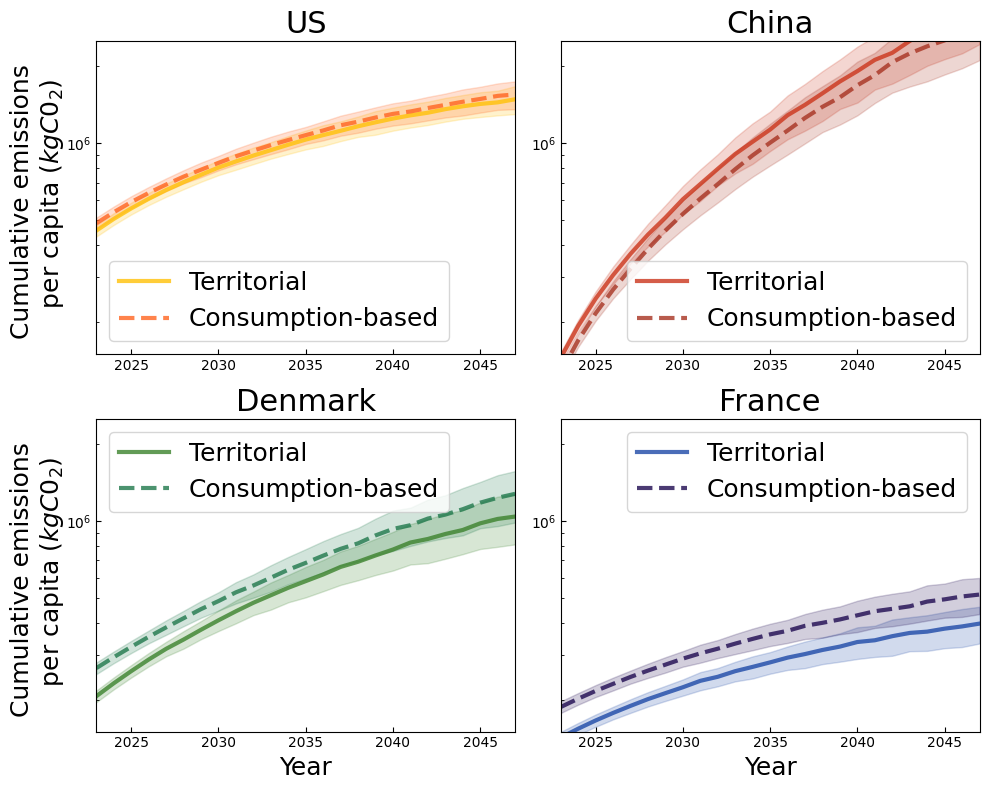

In [60]:
## Lock-in effect and path dependent intenbsities territorialized VS consumption based ##

R2calc = False #If True, calculate R2, else calculate MAE
territorial = False #If True, use territorial emissions, else use consumption-based emissions
intensity = False

fig1 = plt.figure(figsize=(10,8)) 
ax1 = fig1.add_subplot(221)
ax2 = fig1.add_subplot(222)
ax3 = fig1.add_subplot(223)
ax4 = fig1.add_subplot(224)
axlist = [ax1, ax2, ax3, ax4]
if intensity:
    axbislist = [ax1.twinx(), ax2.twinx(), ax3.twinx(), ax4.twinx()]
clist = carr[:13].copy()
clist = [(0, clist[0]), (0.05, clist[1]), (0.1, clist[2]), (0.2, clist[3]), (0.32, clist[4]), (0.4, clist[5]), (0.5, clist[6]), (0.6, clist[7]), (0.65, clist[8]), (0.7, clist[9]), (0.75, clist[10]), (0.82, clist[11]), (1., clist[12])] #[(i*1/11., clist[i]) for i in range(len(clist))]
cmapphase = LinearSegmentedColormap.from_list('cmap', clist) #Create colormap
cadd = [np.array([255./255., 100./255., 31./255., 1.]), carr[4]/1.2, carr[7], carr[12]]

duration = 25 #Duration in years
firstyear = 2022 - duration #Starting year for the study
tflist=np.array(range(duration)) #Time frame list, from 0 to duration-1

temp, logscale = True, True #True to show temperature variation on right axis, True to use a logscale for y axis
countries = ['US', 'china', 'denmark', 'france'] #Different countries to study

for k, territorialstr in enumerate(['territorial', 'consumption-based']):
    for n, country in enumerate(countries):
        ax = axlist[n]
        if intensity:
            axbis = axbislist[n]

        Emperyearlist = np.load(cd + '/data/Emperyearlist_'+country+'_'+territorialstr+'.npy') #Yearly emissions per capita data
        GDPpercapitalist = np.load(cd + '/data/GDPpercapita_'+country+'.npy') #GDP per capita data
        debtpercapitalist = np.load(cd + '/data/debtpercapita_'+country+'.npy') #Debt per capita data
        poplist = np.load(cd + '/data/pop_'+country+'.npy') #Population data
        deficitpercapitalist = np.load(cd + '/data/deficitpercapita_'+country+'.npy') #Deficit per capita data
        tflist=np.array(range(duration)) #Time frame list, from 0 to duration-1
        firstyear = 1960 + GDPpercapitalist.size-duration #Starting year for the study

        # Rescale all lists to have the same size
        Emperyearlist = Emperyearlist[-duration:] 
        GDPpercapitalist = GDPpercapitalist[-duration:]
        debtpercapitalist = debtpercapitalist[-duration:]
        poplist = poplist[-duration:]
        deficitpercapitalist = deficitpercapitalist[-duration:]

        gratelist = [GDPpercapitalist[i] / GDPpercapitalist[i - 1] for i in range(1, len(GDPpercapitalist))] #Growth rate list, from 1 to duration-1
        rlist = np.array(gratelist) - 1. - deficitpercapitalist[1:] / GDPpercapitalist[1:] #Implicit growth rate list from 1 to duration-1
        levlist = deficitpercapitalist / GDPpercapitalist + 1. #Leverage list, from 1 to duration-1
        rholist = np.array([(debtpercapitalist[i+1] - (levlist[i]-1)*GDPpercapitalist[i])/debtpercapitalist[i] for i in range(len(rlist)-1)]) #Interest rate list from 1 to duration-2

        ##Initial conditions##
        GDP0 = GDPpercapitalist[-1]
        rho = np.mean(rholist)
        meanW = np.mean(np.log(1.+rlist))
        sigW = np.std(np.log(1.+rlist))
        inidebt = debtpercapitalist[-1]
        Emintensitylist = Emperyearlist/GDPpercapitalist
        gamma, I0 = -(Emintensitylist[-1] - Emintensitylist[0])/Emintensitylist.size, Emintensitylist[0]
        
        rep = 600 #Number of repetitions
        avgEm = 0. #Initiate average emissions list
        stdsqr = np.zeros(tflist.size) #Initiate standard deviation list
        for i in range(rep):
            model = kelly_debt(5, L, GDP0, 100, rho, 50, gaussian=True, W = meanW, sig=sigW, borroweachstep=True) #Stochastic model
            emissions = np.array([model.emissions(firstyear+tf, Emintensitylist, firstyear, predic = True, em0=sum(Emperyearlist))[0] for tf in tflist])
            avgEm += emissions #Update average emissions
            stdsqr += np.array([(emissions[tf] - avgEm[tf]/(i+(i==0)))**2 for tf in tflist]) #Update standard deviation
        avgEm = avgEm/rep
        stdsqr = np.sqrt(stdsqr/rep)
        
        ax.plot(2023+tflist, avgEm, lw = 3., alpha = 0.8, c=cmapphase(n/4) if k==0 else cadd[n], ls='-' if k==0 else '--', label= str.upper(territorialstr[0])+territorialstr[1:])
        ax.fill_between(2023+tflist, avgEm - stdsqr, avgEm + stdsqr, color=cmapphase(n/4) if k==0 else cadd[n], alpha=0.2)

        if intensity:
            datapdIlist = np.array([np.sum(Emperyearlist[:tau])/(np.sum(GDPpercapitalist[:tau])) for tau in tflist]) #Data for path dependent intensity list from 0 to duration-1
            axbis.plot(firstyear + tflist, datapdIlist, lw = 4.5, alpha = 0.6, ls='-', c=cmapphase(n/4) if k==0 else cadd[n])
            axbis.fill_between([0], [0], [0], color=cmapphase(n/4), alpha=0.7, label=(str.upper(country[0]) + country[1:]) if k==0 else None)

ylimmin, ylimmax = 1.5E5, 2.5E6
for n, ax in enumerate(axlist):
    if intensity:
        axbis = axbislist[n]
        axbis.yaxis.tick_right()
        axbis.yaxis.set_tick_params(direction='in', which='both')
        axbis.set_yscale('log')
        axbis.set_ylim(1E4, 5E5)
        if n%2==1:
            axbis.set_ylabel(r'Intensities ($kgCO_2/USD$)', fontsize=18)
    if n%2==0:
        ax.set_ylabel(r'Cumulative emissions ' + '\n' +r' per capita ($kgC0_2$)', fontsize=18, labelpad=0)
    if n>=2:
        ax.set_xlabel(r'Year', fontsize=18)
    ax.set_xlim(2023, 2023+tflist[-1])
    ax.set_ylim(ylimmin, ylimmax)

    title = 'Path-dependent intensities'
    ax.legend(fontsize=18, loc='best')
    ax.margins(x=0)
    ax.set_yscale('log')
    ax.tick_params(direction='in', which='both')
    ax.set_title(str.upper(countries[n][0]) + countries[n][1:], fontsize=22)

fig1.tight_layout()
fig1.savefig(cd + '/results/lockin_pathdepint_all.pdf')

100%|██████████| 200/200 [00:21<00:00,  9.42it/s]


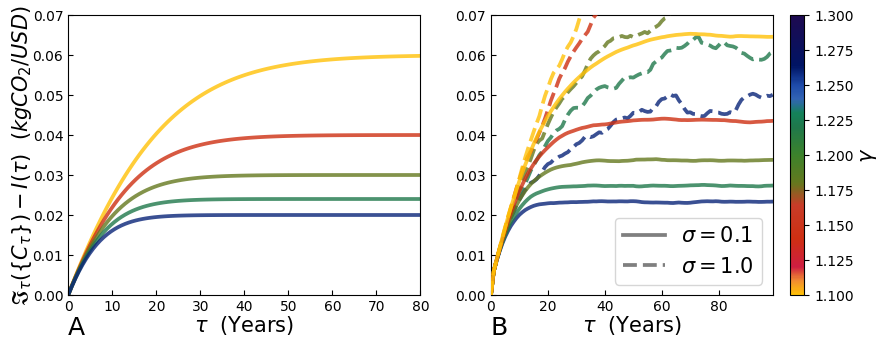

In [ ]:
## Difference between path dependent intensity and yearly intensity ##

eta = 0.006 #Absolute value of the linear slope for the dependency of yearly intensities on time in kgCO2/USD/year
def deltaI(gam,tau):
    return eta*(tau + gam*( (tau+1.)*gam**tau - tau*gam**(tau+1.) - 1. )/((gam - 1.)*(gam**(tau+1) - 1.))) #Analytical difference between intensities

gamlist = [1.1, 1.15, 1.2, 1.25, 1.3] #List of deterministic growth rates

fig1 = plt.figure(figsize=(10,8)) 
ax1 = fig1.add_subplot(221)
ax2 = fig1.add_subplot(222)
ax1.set_xlabel(r'$\tau$  (Years)', labelpad=0, fontsize=15)
ax1.set_ylabel(r'$\mathfrak{I}_{\tau}\left(\{C_{\tau}\}\right) - I(\tau)$  $(kgCO_2/USD)$', labelpad=-1, fontsize=15)

clist = carr[:13].copy()
clist = [(0, clist[0]), (0.05, clist[1]), (0.1, clist[2]), (0.2, clist[3]), (0.32, clist[4]), (0.4, clist[5]), (0.5, clist[6]), (0.6, clist[7]), (0.65, clist[8]), (0.7, clist[9]), (0.75, clist[10]), (0.82, clist[11]), (1., clist[12])] #[(i*1/11., clist[i]) for i in range(len(clist))]
cmapphase = LinearSegmentedColormap.from_list('cmap', clist) #Create the colormap
norm = mpl.colors.Normalize(vmin=gamlist[0], vmax=gamlist[-1], clip=False)

taulist = np.linspace(0., 80., 100) #List of time in years
for i, gam in enumerate(tqdm(gamlist)):
    ax1.plot(taulist, deltaI(gam, taulist), lw = 2.7, alpha = 0.8, c=cmapphase(i/len(gamlist)))
ax1.margins(x=0)
ax1.tick_params(direction='in', which='both')
ax1.set_ylim(0,0.07)
ax1.text(-0.03, -0.01, 'A', fontsize=18)


## Difference between path dependent intensity and yearly intensity stochastic ##

eta = 0.006 #Absolute value of the linear slope for the dependency of yearly intensities on time in kgCO2/USD/year
N=300
sigmalist = [0.05, 0.5]
taulist = np.array(range(100)) #List of time in years
ax2.set_xlabel(r'$\tau$  (Years)', labelpad=0, fontsize=15)
#ax2.set_ylabel(r'$\mathfrak{I}_{\tau}\left(\{C_{\tau}\}\right) - I(\tau)$  $(kgCO_2/USD)$', labelpad=-1, fontsize=15)

clist = carr[:13].copy()
clist = [(0, clist[0]), (0.05, clist[1]), (0.1, clist[2]), (0.2, clist[3]), (0.32, clist[4]), (0.4, clist[5]), (0.5, clist[6]), (0.6, clist[7]), (0.65, clist[8]), (0.7, clist[9]), (0.75, clist[10]), (0.82, clist[11]), (1., clist[12])] #[(i*1/11., clist[i]) for i in range(len(clist))]
cmapphase = LinearSegmentedColormap.from_list('cmap', clist) #Create the colormap

for i, gam in enumerate(gamlist):
    W = gam-1.
    for j, sigma in enumerate(sigmalist):
        S = 0.
        for _ in tqdm(range(N)):
            xilist = np.random.normal(W, sigma, int(taulist.size))
            Deltalist = np.array([ eta*sum([(taup-taupp)*np.prod(np.exp(xilist[:taupp])) for taupp in range(int(taup))])/(sum([np.prod(np.exp(xilist[:taupp])) for taupp in range(int(taup))])+1E-10) for taup in taulist])
            #Deltalist = np.array([ eta*sum([(taup-taupp)*(1.1)**taupp for taupp in range(int(taup))])/(sum([(1.1)**taupp for taupp in range(int(taup))])+1E-10) for taup in taulist])
            S += Deltalist
            #ax2.plot(taulist, Deltalist, lw = 2.5, alpha = 10/N, c=cmapphase(i/len(sigmalist)), zorder = 5-i)
        ax2.plot(taulist, S/N, lw = 2.7, alpha = 0.8, c=cmapphase(i/len(gamlist)), ls='-' if j==0 else '--', zorder = 10-i)

for j, sigma in enumerate(sigmalist):
    ax2.plot(0, 0, label=r'$\sigma={}$'.format(str(sigma)[:4]), ls='-' if j==0 else '--', c='black', alpha=0.5, lw=2.7)
cbar = fig1.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmapphase), ax=ax2, label=r'$W$')
cbar.set_label(r'$W$', size=15)
ax2.set_ylim(0, 0.07)
ax2.margins(x=0)
ax2.tick_params(direction='in', which='both')
ax2.legend(loc = 'best', fontsize=15)
ax2.text(-0.03, -0.01, 'B', fontsize=18)

fig1.savefig(cd + r'/results/diffI_vs_tau.pdf')

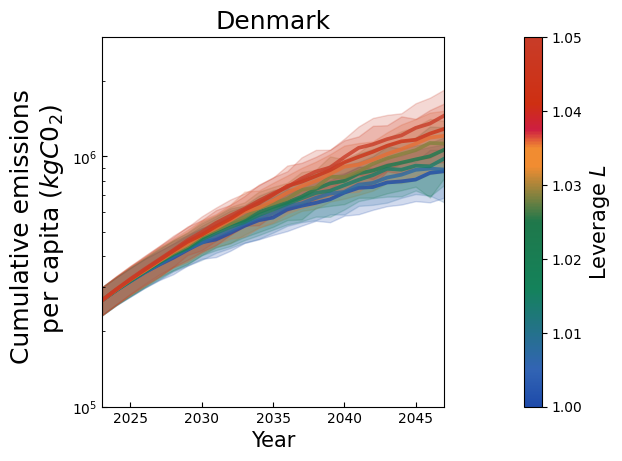

In [11]:
## Predicted cumulative emissions ##
country = "china" #Pick the country among US, china, denmark, france
duration = 25 #Duration in years
firstyear = 2022 - duration #Starting year for the study
tflist=np.array(range(duration)) #Time frame list, from 0 to duration-1
territorial = False #If True, use territorial emissions, else use consumption-based emissions
territorialstr = 'territorial' if territorial else 'consumption-based'

temp, logscale = False, True #True to show temperature variation on right axis, True to use a logscale for y axis

Emperyearlist = np.load(cd + '/data/Emperyearlist_'+country+'_'+territorialstr+'.npy') #Yearly emissions per capita data
GDPpercapitalist = np.load(cd + '/data/GDPpercapita_'+country+'.npy') #GDP per capita data
debtpercapitalist = np.load(cd + '/data/debtpercapita_'+country+'.npy') #Debt per capita data
poplist = np.load(cd + '/data/pop_'+country+'.npy') #Population data
deficitpercapitalist = np.load(cd + '/data/deficitpercapita_'+country+'.npy') #Deficit per capita data
tflist=np.array(range(duration)) #Time frame list, from 0 to duration-1
firstyear = 1960 + GDPpercapitalist.size-duration #Starting year for the study

# Rescale all lists to have the same size
Emperyearlist = Emperyearlist[-duration:] 
GDPpercapitalist = GDPpercapitalist[-duration:]
debtpercapitalist = debtpercapitalist[-duration:]
poplist = poplist[-duration:]
deficitpercapitalist = deficitpercapitalist[-duration:]

gratelist = [GDPpercapitalist[i] / GDPpercapitalist[i - 1] for i in range(1, len(GDPpercapitalist))] #Growth rate list, from 1 to duration-1
rlist = np.array(gratelist) - 1. - deficitpercapitalist[1:] / GDPpercapitalist[1:] #Implicit growth rate list from 1 to duration-1
levlist = deficitpercapitalist / GDPpercapitalist + 1. #Leverage list, from 1 to duration-1
rholist = np.array([(debtpercapitalist[i+1] - (levlist[i]-1)*GDPpercapitalist[i])/debtpercapitalist[i] for i in range(len(rlist)-1)]) #Interest rate list from 1 to duration-2

##Initial conditions##
GDP0 = GDPpercapitalist[-1]
rho = np.mean(rholist)
meanW = np.mean(np.log(1.+rlist))
sigW = np.std(np.log(1.+rlist))
inidebt = debtpercapitalist[0]
Emintensitylist = Emperyearlist/GDPpercapitalist
gamma, I0 = -(Emintensitylist[-1] - Emintensitylist[0])/Emintensitylist.size, Emintensitylist[0]

Levlist = np.linspace(1,1.05, 8) #List of leverage values to study

title = r'Leverage and $CO_2$ emissions in ' + 'the US' if country=='US' else '' + str.upper(country[0]) + country[1:]
fig1 = plt.figure() 
ax1 = fig1.add_subplot(111)
if temp:
    ax2 = ax1.twinx()
    ax2.yaxis.tick_right()
    ax2.yaxis.set_tick_params(direction='in', which='both')
    ax2.set_ylabel(r'$\Delta T$ ($^{\circ}$C)', fontsize=15, labelpad=0)
cdeb = list(carr[7:12]).copy() #Update color list
cdeb.reverse() #Update colorlist
clist = (cdeb+list(carr[:2])+list(carr[1:5])+list(carr[14:])).copy() #Update colorlist
clist = [(0, clist[1]), (0.1, clist[2]), (0.32, clist[3]),  (0.5, clist[4]), (0.65, clist[6]), (0.7, clist[7]), (0.75, clist[8]), (0.82, clist[9]), (1., clist[10])] #[(i*1/11., clist[i]) for i in range(len(clist))]
cmapphase = LinearSegmentedColormap.from_list('cmap', clist) #Create the colormap
norm = mpl.colors.Normalize(vmin=Levlist[0], vmax=Levlist[-1], clip=False)

rep = 100 #Number of repetitions
avgEm = [0. for _ in range(len(Levlist))] #Initiate average emissions list
stdsqr = [np.zeros(tflist.size) for _ in range(len(Levlist))] #Initiate standard deviation list
for i in range(rep):
    for j,L in enumerate(Levlist):
        model = kelly_debt(5, L, GDP0, 100, rho, 50, gaussian=True, W = meanW, sig=sigW, borroweachstep=True) #Stochastic model
        emissions = np.array([model.emissions(firstyear+tf, Emintensitylist, firstyear, predic = True, em0=sum(Emperyearlist))[0] for tf in tflist])
        avgEm[j] += emissions #Update average emissions
        stdsqr[j] += np.array([(emissions[tf] - avgEm[j][tf]/(i+(i==0)))**2 for tf in tflist]) #Update standard deviation
avgEm = [em/rep for em in avgEm]
stdsqr = [np.sqrt(st/rep) for st in stdsqr]
for j,L in enumerate(Levlist):
    ax1.plot(2023+tflist, avgEm[j], lw = 2.7, alpha = 0.8, c=cmapphase((L-1)/(Levlist[-1]-1)), label=r'$L = {}$'.format(str(L)[:5]))
    ax1.fill_between(2023+tflist, avgEm[j] - stdsqr[j], avgEm[j] + stdsqr[j], color=cmapphase((L-1)/(Levlist[-1]-1)), alpha=0.2)

ylimmin, ylimmax = 1E5, 3E6
cbar = fig1.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmapphase), ax=ax1, label=r'$L$', pad=0.16)
cbar.set_label(r'Leverage $L$', size=15)
ax1.set_xlabel(r'Year', fontsize=15)
ax1.set_ylabel(r'Cumulative emissions ' + '\n' +r' per capita ($kgC0_2$)', fontsize=18)
ax1.margins(x=0)
if logscale:
    ax1.set_yscale('log')
if temp:
    if logscale:
        ax2.set_yscale('log')
    worldpop = 8E9
    ax2.set_ylim(ylimmin*1.6*1E-5, ylimmax*1.6*1E-15*worldpop)
ax1.set_xlim(2023+tflist[0],2023+tflist[-1])
ax1.set_ylim(ylimmin,ylimmax)
ax1.set_title(str.upper(country[0]) + country[1:], fontsize=18)
ax1.tick_params(direction='in', which='both')
fig1.savefig(cd + '/results/emissions_pred'+country+'_'+territorialstr+'.pdf')

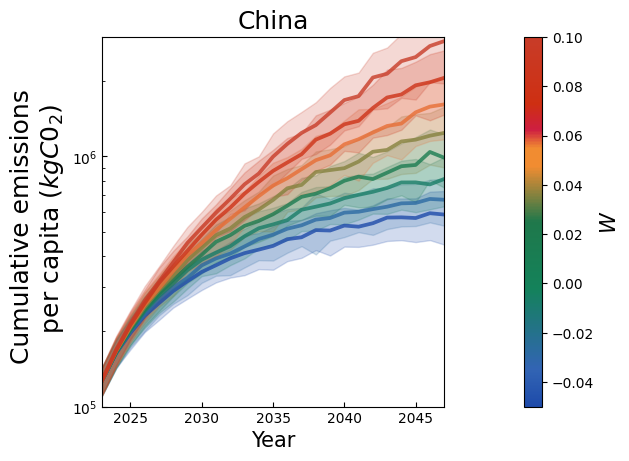

In [ ]:
## Predicted cumulative emissions depending on W ##
country = "" #Pick the country among US, china, denmark, france
duration = 25 #Duration in years
firstyear = 2022 - duration #Starting year for the study
tflist=np.array(range(duration)) #Time frame list, from 0 to duration-1
territorial = False #If True, use territorial emissions, else use consumption-based emissions
territorialstr = 'territorial' if territorial else 'consumption-based'

temp, logscale = False, True #True to show temperature variation on right axis, True to use a logscale for y axis

Emperyearlist = np.load(cd + '/data/Emperyearlist_'+country+'_'+territorialstr+'.npy') #Yearly emissions per capita data
GDPpercapitalist = np.load(cd + '/data/GDPpercapita_'+country+'.npy') #GDP per capita data
debtpercapitalist = np.load(cd + '/data/debtpercapita_'+country+'.npy') #Debt per capita data
poplist = np.load(cd + '/data/pop_'+country+'.npy') #Population data
deficitpercapitalist = np.load(cd + '/data/deficitpercapita_'+country+'.npy') #Deficit per capita data
tflist=np.array(range(duration)) #Time frame list, from 0 to duration-1
firstyear = 1960 + GDPpercapitalist.size-duration #Starting year for the study

# Rescale all lists to have the same size
Emperyearlist = Emperyearlist[-duration:] 
GDPpercapitalist = GDPpercapitalist[-duration:]
debtpercapitalist = debtpercapitalist[-duration:]
poplist = poplist[-duration:]
deficitpercapitalist = deficitpercapitalist[-duration:]

gratelist = [GDPpercapitalist[i] / GDPpercapitalist[i - 1] for i in range(1, len(GDPpercapitalist))] #Growth rate list, from 1 to duration-1
rlist = np.array(gratelist) - 1. - deficitpercapitalist[1:] / GDPpercapitalist[1:] #Implicit growth rate list from 1 to duration-1
levlist = deficitpercapitalist / GDPpercapitalist + 1. #Leverage list, from 1 to duration-1
rholist = np.array([(debtpercapitalist[i+1] - (levlist[i]-1)*GDPpercapitalist[i])/debtpercapitalist[i] for i in range(len(rlist)-1)]) #Interest rate list from 1 to duration-2

##Initial conditions##
GDP0 = GDPpercapitalist[-1]
rho = np.mean(rholist)
meanW = np.mean(np.log(1.+rlist))
sigW = np.std(np.log(1.+rlist))
inidebt = debtpercapitalist[0]
Emintensitylist = Emperyearlist/GDPpercapitalist
gamma, I0 = -(Emintensitylist[-1] - Emintensitylist[0])/Emintensitylist.size, Emintensitylist[0]

Wlist = np.linspace(-0.05,.1, 8) #List of leverage values to study

title = r'Leverage and $CO_2$ emissions in ' + 'the US' if country=='US' else '' + str.upper(country[0]) + country[1:]
fig1 = plt.figure() 
ax1 = fig1.add_subplot(111)
if temp:
    ax2 = ax1.twinx()
    ax2.yaxis.tick_right()
    ax2.yaxis.set_tick_params(direction='in', which='both')
    ax2.set_ylabel(r'$\Delta T$ ($^{\circ}$C)', fontsize=15, labelpad=0)
cdeb = list(carr[7:12]).copy() #Update color list
cdeb.reverse() #Update colorlist
clist = (cdeb+list(carr[:2])+list(carr[1:5])+list(carr[14:])).copy() #Update colorlist
clist = [(0, clist[1]), (0.1, clist[2]), (0.32, clist[3]),  (0.5, clist[4]), (0.65, clist[6]), (0.7, clist[7]), (0.75, clist[8]), (0.82, clist[9]), (1., clist[10])] #[(i*1/11., clist[i]) for i in range(len(clist))]
cmapphase = LinearSegmentedColormap.from_list('cmap', clist) #Create the colormap
norm = mpl.colors.Normalize(vmin=Wlist[0], vmax=Wlist[-1], clip=False)

rep = 100 #Number of repetitions
avgEm = [0. for _ in range(len(Wlist))] #Initiate average emissions list
stdsqr = [np.zeros(tflist.size) for _ in range(len(Wlist))] #Initiate standard deviation list
for i in range(rep):
    for j,W in enumerate(Wlist):
        model = kelly_debt(5, np.average(levlist), GDP0, 100, rho, 50, gaussian=True, W = W, sig=sigW, borroweachstep=True) #Stochastic model
        emissions = np.array([model.emissions(firstyear+tf, Emintensitylist, firstyear, predic = True, em0=sum(Emperyearlist))[0] for tf in tflist])
        avgEm[j] += emissions #Update average emissions
        stdsqr[j] += np.array([(emissions[tf] - avgEm[j][tf]/(i+(i==0)))**2 for tf in tflist]) #Update standard deviation
avgEm = [em/rep for em in avgEm]
stdsqr = [np.sqrt(st/rep) for st in stdsqr]
for j,W in enumerate(Wlist):
    ax1.plot(2023+tflist, avgEm[j], lw = 2.7, alpha = 0.8, c=cmapphase((W-Wlist[0])/(Wlist[-1]-Wlist[0])), label=r'$L = {}$'.format(str(L)[:5]))
    ax1.fill_between(2023+tflist, avgEm[j] - stdsqr[j], avgEm[j] + stdsqr[j], color=cmapphase((W-Wlist[0])/(Wlist[-1]-Wlist[0])), alpha=0.2)

ylimmin, ylimmax = 1E5, 3E6
cbar = fig1.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmapphase), ax=ax1, label=r'$W$', pad=0.16)
cbar.set_label(r'$W$', size=15)
ax1.set_xlabel(r'Year', fontsize=15)
ax1.set_ylabel(r'Cumulative emissions ' + '\n' +r' per capita ($kgC0_2$)', fontsize=18)
ax1.margins(x=0)
if logscale:
    ax1.set_yscale('log')
if temp:
    if logscale:
        ax2.set_yscale('log')
    worldpop = 8E9
    ax2.set_ylim(ylimmin*1.6*1E-5, ylimmax*1.6*1E-15*worldpop)
ax1.set_xlim(2023+tflist[0],2023+tflist[-1])
ax1.set_ylim(ylimmin,ylimmax)
ax1.set_title(str.upper(country[0]) + country[1:], fontsize=18)
ax1.tick_params(direction='in', which='both')
fig1.savefig(cd + '/results/emissions_pred_W_'+country+'_'+territorialstr+'.pdf')

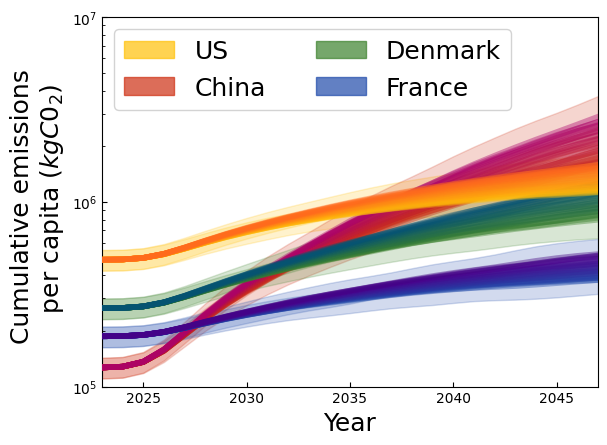

In [62]:
## Predicted cumulative emissions varying growth rate ##

countries = ['US', 'china', 'denmark', 'france']
duration = 25 #Duration in years
firstyear = 2022 - duration #Starting year for the study
tflist=np.array(range(duration)) #Time frame list, from 0 to duration-1
territorial = False #If True, use territorial emissions, else use consumption-based emissions
territorialstr = 'territorial' if territorial else 'consumption-based'

temp, logscale = False, True #True to show temperature variation on right axis, True to use a logscale for y axis

clist = carr[:13].copy()
clist = [(0, clist[0]), (0.249, np.array([255./255., 100./255., 31./255., 1.])), (0.25, clist[3]), (0.499, np.array([170./255., 0./255., 110./255., 1.])), (0.5, clist[6]), (0.749, np.array([2./255., 80./255., 120./255., 1.])), (0.75, clist[10]), (0.99, np.array([75./255., 0./255., 140./255., 1.])), (1., clist[12])] #[(i*1/11., clist[i]) for i in range(len(clist))]
cmapphase = LinearSegmentedColormap.from_list('cmap', clist) #Create colormap

Levlist = np.linspace(1,1.05, 30) #List of leverage values to study

fig1 = plt.figure() 
ax1 = fig1.add_subplot(111)
if temp:
    ax2 = ax1.twinx()
    ax2.yaxis.tick_right()
    ax2.yaxis.set_tick_params(direction='in', which='both')
    ax2.set_ylabel(r'$\Delta T$ ($^{\circ}$C)', fontsize=15, labelpad=0)
    
for n, country in enumerate(countries):
    Emperyearlist = np.load(cd + '/data/Emperyearlist_'+country+'_'+territorialstr+'.npy') #Yearly emissions per capita data
    GDPpercapitalist = np.load(cd + '/data/GDPpercapita_'+country+'.npy') #GDP per capita data
    debtpercapitalist = np.load(cd + '/data/debtpercapita_'+country+'.npy') #Debt per capita data
    poplist = np.load(cd + '/data/pop_'+country+'.npy') #Population data
    deficitpercapitalist = np.load(cd + '/data/deficitpercapita_'+country+'.npy') #Deficit per capita data
    tflist=np.array(range(duration)) #Time frame list, from 0 to duration-1
    firstyear = 1960 + GDPpercapitalist.size-duration #Starting year for the study

    # Rescale all lists to have the same size
    Emperyearlist = Emperyearlist[-duration:] 
    GDPpercapitalist = GDPpercapitalist[-duration:]
    debtpercapitalist = debtpercapitalist[-duration:]
    poplist = poplist[-duration:]
    deficitpercapitalist = deficitpercapitalist[-duration:]

    gratelist = [GDPpercapitalist[i] / GDPpercapitalist[i - 1] for i in range(1, len(GDPpercapitalist))] #Growth rate list, from 1 to duration-1
    rlist = np.array(gratelist) - 1. - deficitpercapitalist[1:] / GDPpercapitalist[1:] #Implicit growth rate list from 1 to duration-1
    levlist = deficitpercapitalist / GDPpercapitalist + 1. #Leverage list, from 1 to duration-1
    rholist = np.array([(debtpercapitalist[i+1] - (levlist[i]-1)*GDPpercapitalist[i])/debtpercapitalist[i] for i in range(len(rlist)-1)]) #Interest rate list from 1 to duration-2

    ##Initial conditions##
    GDP0 = GDPpercapitalist[-1]
    rho = np.mean(rholist)
    meanW = np.mean(np.log(1.+rlist))
    sigW = np.std(np.log(1.+rlist))
    inidebt = debtpercapitalist[0]
    Emintensitylist = Emperyearlist/GDPpercapitalist
    gamma, I0 = -(Emintensitylist[-1] - Emintensitylist[0])/Emintensitylist.size, Emintensitylist[0]

    rep = 100 #Number of repetitions
    avgEm = [0. for _ in range(len(Levlist))] #Initiate average emissions list
    stdsqr = [np.zeros(tflist.size) for _ in range(len(Levlist))] #Initiate standard deviation list
    for i in range(rep):
        for j,L in enumerate(Levlist):
            model = kelly_debt(5, L, GDP0, 100, rho, 50, gaussian=True, W = meanW, sig=sigW, borroweachstep=True) #Stochastic model
            emissions = np.array([model.emissions(firstyear+tf, Emintensitylist, firstyear, predic = True, em0=sum(Emperyearlist))[0] for tf in tflist])
            avgEm[j] += emissions #Update average emissions
            stdsqr[j] += np.array([(emissions[tf] - avgEm[j][tf]/(i+(i==0)))**2 for tf in tflist]) #Update standard deviation
    avgEm = [em/rep for em in avgEm]
    stdsqr = [np.sqrt(st/rep) for st in stdsqr]
    for j, Em in enumerate(avgEm):
        for _ in range(5):
            avgEm[j] = smoothen(avgEm[j], nm=2)
            stdsqr[j] = smoothen(stdsqr[j], nm=2)
    avgEm, stdsqr = np.array(avgEm), np.array(stdsqr)
    for j,L in enumerate(Levlist):
        ax1.plot(2023+tflist, avgEm[j], lw = 4., alpha = 0.4, c=cmapphase(n/4 + 1/4*(j/len(Levlist))), zorder = 6+(5 if country == 'US' else 2))
        if j%(len(Levlist)-1)==0:
            ax1.fill_between(2023+tflist, avgEm[j] - stdsqr[j], avgEm[j] + stdsqr[j], color=cmapphase(n/4), alpha=0.2)
            ax1.fill_between([0], [0], [0], color=cmapphase(n/4), alpha=0.7, label = (str.upper(country[0]) + country[1:]) if j==0 else None, zorder = (5 if country == 'US' else 2))


ylimmin, ylimmax = 1E5, 1E7
ax1.set_xlabel(r'Year', fontsize=18)
ax1.set_ylabel(r'Cumulative emissions ' + '\n' +r' per capita ($kgC0_2$)', fontsize=18)
ax1.margins(x=0)
if logscale:
    ax1.set_yscale('log')
if temp:
    if logscale:
        ax2.set_yscale('log')
    worldpop = 8E9
    ax2.set_ylim(ylimmin*1.6*1E-5, ylimmax*1.6*1E-15*worldpop)
ax1.legend(fontsize=18, loc='best', ncol=2, framealpha=.85).set_zorder(15)
ax1.set_xlim(2023+tflist[0],2023+tflist[-1])
ax1.set_ylim(ylimmin,ylimmax)
fig1.figsize=(12,12)
ax1.tick_params(direction='in', which='both')
fig1.savefig(cd + '/results/emissions_pred_lev_all_'+territorialstr+'.pdf')

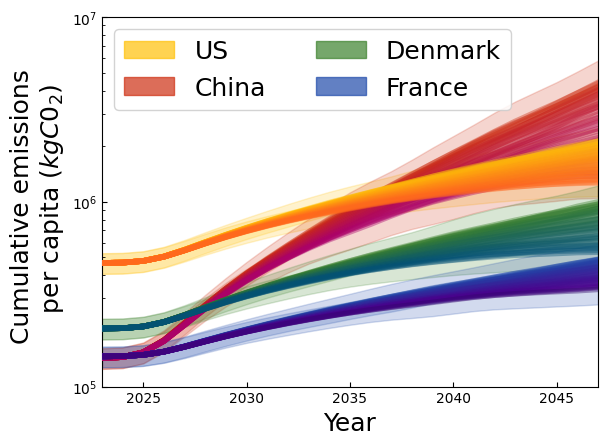

In [64]:
## Predicted cumulative emissions varying growth rate ##

countries = ['US', 'china', 'denmark', 'france']
duration = 25 #Duration in years
firstyear = 2022 - duration #Starting year for the study
tflist=np.array(range(duration)) #Time frame list, from 0 to duration-1
territorial = False #If True, use territorial emissions, else use consumption-based emissions
territorialstr = 'territorial' if territorial else 'consumption-based'

temp, logscale = False, True #True to show temperature variation on right axis, True to use a logscale for y axis

clist = carr[:13].copy()
clist = [(0, clist[0]), (0.249, np.array([255./255., 100./255., 31./255., 1.])), (0.25, clist[3]), (0.499, np.array([170./255., 0./255., 110./255., 1.])), (0.5, clist[6]), (0.749, np.array([2./255., 80./255., 120./255., 1.])), (0.75, clist[10]), (0.99, np.array([75./255., 0./255., 140./255., 1.])), (1., clist[12])] #[(i*1/11., clist[i]) for i in range(len(clist))]
cmapphase = LinearSegmentedColormap.from_list('cmap', clist) #Create colormap


fig1 = plt.figure() 
ax1 = fig1.add_subplot(111)
if temp:
    ax2 = ax1.twinx()
    ax2.yaxis.tick_right()
    ax2.yaxis.set_tick_params(direction='in', which='both')
    ax2.set_ylabel(r'$\Delta T$ ($^{\circ}$C)', fontsize=15, labelpad=0)
    
for n, country in enumerate(countries):
    Emperyearlist = np.load(cd + '/data/Emperyearlist_'+country+'.npy') #Yearly emissions per capita data
    GDPpercapitalist = np.load(cd + '/data/GDPpercapita_'+country+'.npy') #GDP per capita data
    debtpercapitalist = np.load(cd + '/data/debtpercapita_'+country+'.npy') #Debt per capita data
    poplist = np.load(cd + '/data/pop_'+country+'.npy') #Population data
    deficitpercapitalist = np.load(cd + '/data/deficitpercapita_'+country+'.npy') #Deficit per capita data
    tflist=np.array(range(duration)) #Time frame list, from 0 to duration-1
    firstyear = 1960 + GDPpercapitalist.size-duration #Starting year for the study

    # Rescale all lists to have the same size
    Emperyearlist = Emperyearlist[-duration:] 
    GDPpercapitalist = GDPpercapitalist[-duration:]
    debtpercapitalist = debtpercapitalist[-duration:]
    poplist = poplist[-duration:]
    deficitpercapitalist = deficitpercapitalist[-duration:]

    gratelist = [GDPpercapitalist[i] / GDPpercapitalist[i - 1] for i in range(1, len(GDPpercapitalist))] #Growth rate list, from 1 to duration-1
    rlist = np.array(gratelist) - 1. - deficitpercapitalist[1:] / GDPpercapitalist[1:] #Implicit growth rate list from 1 to duration-1
    levlist = deficitpercapitalist / GDPpercapitalist + 1. #Leverage list, from 1 to duration-1
    rholist = np.array([(debtpercapitalist[i+1] - (levlist[i]-1)*GDPpercapitalist[i])/debtpercapitalist[i] for i in range(len(rlist)-1)]) #Interest rate list from 1 to duration-2

    ##Initial conditions##
    GDP0 = GDPpercapitalist[-1]
    rho = np.mean(rholist)
    meanW = np.mean(np.log(1.+rlist))
    sigW = np.std(np.log(1.+rlist))
    inidebt = debtpercapitalist[0]
    Emintensitylist = Emperyearlist/GDPpercapitalist
    gamma, I0 = -(Emintensitylist[-1] - Emintensitylist[0])/Emintensitylist.size, Emintensitylist[0]
    gamlist = np.linspace(0., 1.5*gamma, 40) #List of leverage values to study

    rep = 100 #Number of repetitions
    avgEm = [0. for _ in range(len(gamlist))] #Initiate average emissions list
    stdsqr = [np.zeros(tflist.size) for _ in range(len(gamlist))] #Initiate standard deviation list
    for i in range(rep):
        for j,gam in enumerate(gamlist):
            Emintensitylist = np.array([I0 - gam*i for i in tflist]) #Linear deterministic emissions intensity
            model = kelly_debt(5, np.average(levlist), GDP0, 100, rho, 50, gaussian=True, W = meanW, sig=sigW, borroweachstep=True) #Stochastic model
            emissions = np.array([model.emissions(firstyear+tf, Emintensitylist, firstyear, predic = True, em0=sum(Emperyearlist))[0] for tf in tflist])
            avgEm[j] += emissions #Update average emissions
            stdsqr[j] += np.array([(emissions[tf] - avgEm[j][tf]/(i+(i==0)))**2 for tf in tflist]) #Update standard deviation
    avgEm = [em/rep for em in avgEm]
    stdsqr = [np.sqrt(st/rep) for st in stdsqr]
    for j, Em in enumerate(avgEm):
        for _ in range(5):
            avgEm[j] = smoothen(avgEm[j], nm=2)
            stdsqr[j] = smoothen(stdsqr[j], nm=2)
    avgEm, stdsqr = np.array(avgEm), np.array(stdsqr)
    for j,gam in enumerate(gamlist):
        ax1.plot(2023+tflist, avgEm[j], lw = 4., alpha = 0.4, c=cmapphase(n/4 + 1/4*(j/len(gamlist))), zorder = 6+(5 if country == 'US' else 2))
        if j%(len(gamlist)-1)==0:
            ax1.fill_between(2023+tflist, avgEm[j] - stdsqr[j], avgEm[j] + stdsqr[j], color=cmapphase(n/4), alpha=0.2)
            ax1.fill_between([0], [0], [0], color=cmapphase(n/4), alpha=0.7, label = (str.upper(country[0]) + country[1:]) if j==0 else None, zorder = (5 if country == 'US' else 2))

ylimmin, ylimmax = 1E5, 1E7
ax1.set_xlabel(r'Year', fontsize=18)
ax1.set_ylabel(r'Cumulative emissions ' + '\n' +r' per capita ($kgC0_2$)', fontsize=18)
ax1.margins(x=0)
if logscale:
    ax1.set_yscale('log')
if temp:
    if logscale:
        ax2.set_yscale('log')
    worldpop = 8E9
    ax2.set_ylim(ylimmin*1.6*1E-5, ylimmax*1.6*1E-15*worldpop)
ax1.legend(fontsize=18, loc='best', ncol=2, framealpha=.85).set_zorder(15)
ax1.set_xlim(2023+tflist[0],2023+tflist[-1])
ax1.set_ylim(ylimmin,ylimmax)
fig1.figsize=(10,10)
ax1.tick_params(direction='in', which='both')
fig1.savefig(cd + '/results/emissions_pred_intens_all_'+territorialstr+'.pdf')

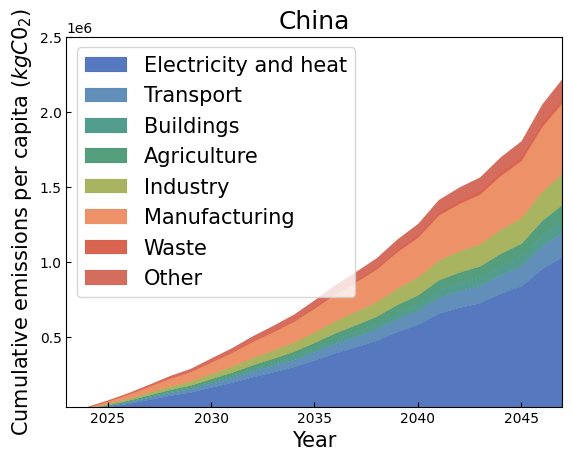

In [ ]:
## Predicted emissions per sector ##
country = "china" #Pick the country among US, china, denmark, france
duration = 25 #Duration in years
firstyear = 2022 - duration #Starting year for the study
tflist=np.array(range(duration)) #Time frame list, from 0 to duration-1
territorial = False #If True, use territorial emissions, else use consumption-based emissions
territorialstr = 'territorial' if territorial else 'consumption-based'

temp, logscale = False, False

Emperyearlist = np.load(cd + '/data/Emperyearlist_'+country+'_'+territorialstr+'.npy') #Yearly emissions per capita data
GDPpercapitalist = np.load(cd + '/data/GDPpercapita_'+country+'.npy') #GDP per capita data
debtpercapitalist = np.load(cd + '/data/debtpercapita_'+country+'.npy') #Debt per capita data
poplist = np.load(cd + '/data/pop_'+country+'.npy') #Population data
deficitpercapitalist = np.load(cd + '/data/deficitpercapita_'+country+'.npy') #Deficit per capita data
tflist=np.array(range(duration)) #Time frame list, from 0 to duration-1
firstyear = 1960 + GDPpercapitalist.size-duration

#Starting year for the study
Emperyearlist = Emperyearlist[-duration:]
GDPpercapitalist = GDPpercapitalist[-duration:]
debtpercapitalist = debtpercapitalist[-duration:]
poplist = poplist[-duration:]
deficitpercapitalist = deficitpercapitalist[-duration:]

gratelist = [GDPpercapitalist[i] / GDPpercapitalist[i - 1] for i in range(1, len(GDPpercapitalist))] #Growth rate list, from 1 to duration-1
rlist = np.array(gratelist) - 1. - deficitpercapitalist[1:] / GDPpercapitalist[1:] #Implicit growth rate list from 1 to duration-1
levlist = deficitpercapitalist / GDPpercapitalist + 1. #Leverage list, from 1 to duration-1
rholist = np.array([(debtpercapitalist[i+1] - (levlist[i]-1)*GDPpercapitalist[i])/debtpercapitalist[i] for i in range(len(rlist)-1)]) #Interest rate list from 1 to duration-2

##Initial conditions##
GDP0 = GDPpercapitalist[-1] #Initial GDP per capita
rho = np.mean(rholist) #Average interest rate
meanW = np.mean(np.log(1.+rlist)) #Mean of the log of the implicit growth rate
sigW = np.std(np.log(1.+rlist)) #Standard deviation of the log of the implicit growth rate
inidebt = debtpercapitalist[0] #Initial debt per capita
Emintensitylist = Emperyearlist/GDPpercapitalist #Emissions intensity list, from 0 to duration-1
gamma, I0 = -(Emintensitylist[-1] - Emintensitylist[0])/Emintensitylist.size, Emintensitylist[0] #Linear parameters for the emissions intensity

L = 1.02 #Average leverage, can be changed to study different leverage values

title = r'Leverage and $CO_2$ emissions in ' + 'the US' if country=='US' else '' + str.upper(country[0]) + country[1:]
fig1 = plt.figure() 
ax1 = fig1.add_subplot(111)
if temp:
    ax2 = ax1.twinx()
    ax2.yaxis.tick_right()
    ax2.yaxis.set_tick_params(direction='in', which='both')
    ax2.set_ylabel(r'$\Delta T$ ($^{\circ}$C)', fontsize=15, labelpad=0)
cdeb = list(carr[7:12]).copy()
cdeb.reverse()
clist = (cdeb+list(carr[:2])+list(carr[1:5])+list(carr[14:])).copy()
clist = [(0, clist[1]), (0.1, clist[2]), (0.32, clist[3]),  (0.5, clist[4]), (0.65, clist[5]), (0.7, clist[7]), (0.75, clist[8]), (0.82, clist[9]), (1., clist[10])] #[(i*1/11., clist[i]) for i in range(len(clist))]
cmapphase = LinearSegmentedColormap.from_list('cmap', clist) #Create the colormap

rep = 100 #Number of repetitions
avgEm = 0. #Initiate average emissions
for i in range(rep):
    model = kelly_debt(5, L, GDP0, 100, rho, 50, gaussian=True, W = meanW, sig=sigW, borroweachstep=True)
    emissions = np.array([model.emissions(firstyear+tf, Emintensitylist, firstyear, predic = True)[0] for tf in tflist])
    avgEm += emissions
avgEm = avgEm/rep

#for US
repart_sectors = np.load(cd + '/data/repart_sectors_'+country+'.npy')

sector_title = ['Electricity and heat', 'Transport', 'Buildings', 'Agriculture', 'Industry', 'Manufacturing', 'Waste', 'Other']
for j in range(len(repart_sectors)):
    x0, x1 = sum(repart_sectors[:j]), sum(repart_sectors[:j+1])
    ax1.fill_between(2023+tflist, x0*avgEm, x1*avgEm, lw = .1, alpha = 0.75, color=cmapphase(j/(len(repart_sectors)-1)), label=sector_title[j])

ax1.legend(fontsize=15, loc='upper left')
ylimmin, ylimmax = 4E4, 2.5E6
ax1.set_xlabel(r'Year', fontsize=15)
ax1.set_ylabel(r'Cumulative emissions ' + '\n' +r' per capita ($kgC0_2$)', fontsize=18)
ax1.margins(x=0)
if logscale:
    ax1.set_yscale('log')
if temp:
    if logscale:
        ax2.set_yscale('log')
    worldpop = 8E9
    ax2.set_ylim(ylimmin*1.6*1E-5, ylimmax*1.6*1E-15*worldpop)
ax1.set_xlim(2023+tflist[0],2023+tflist[-1])
ax1.set_ylim(ylimmin,ylimmax)
ax1.set_title(title, fontsize=18)
ax1.tick_params(direction='in', which='both')
fig1.savefig(cd + '/results/emissions_pred_persector'+country+'_'+territorialstr+'.pdf')

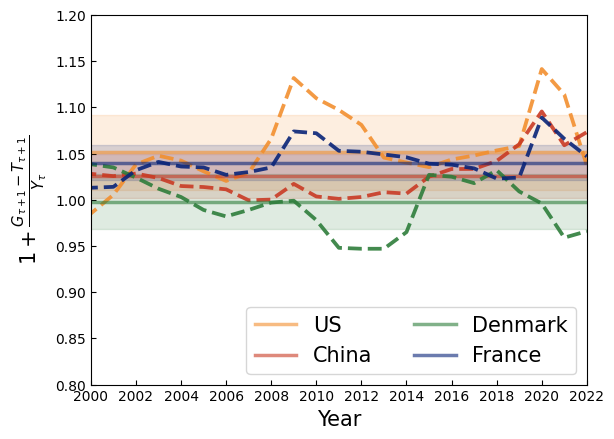

In [2]:
## Study Primary Deficit_{t+1}/GDP_{t} ratio ##

## GDP and Debt ##

countries = ['US', 'china', 'denmark', 'france']
duration = 25 #Duration in years

title = r'Primary deficit to GDP'
fig1 = plt.figure() 
ax1 = fig1.add_subplot(111)
clist = carr[:13].copy()
clist = [(0, clist[0]), (0.05, clist[1]), (0.1, clist[2]), (0.2, clist[3]), (0.32, clist[4]), (0.4, clist[5]), (0.5, clist[6]), (0.6, clist[7]), (0.65, clist[8]), (0.7, clist[9]), (0.75, clist[10]), (0.82, clist[11]), (1., clist[12])] #[(i*1/11., clist[i]) for i in range(len(clist))]
cmapphase = LinearSegmentedColormap.from_list('cmap', clist) #Create the colormap

for n, country in enumerate(countries):
    Emperyearlist = np.load(cd + '/data/Emperyearlist_'+country+'.npy') #Yearly emissions per capita data
    GDPpercapitalist = np.load(cd + '/data/GDPpercapita_'+country+'.npy') #GDP per capita data
    debtpercapitalist = np.load(cd + '/data/debtpercapita_'+country+'.npy') #Debt per capita data
    poplist = np.load(cd + '/data/pop_'+country+'.npy') #Population data
    deficitpercapitalist = np.load(cd + '/data/deficitpercapita_'+country+'.npy') #Deficit per capita data
    tflist=np.array(range(duration)) #Time frame list, from 0 to duration-1
    firstyear = 1960 + GDPpercapitalist.size-duration #Starting year for the study

    # Rescale all lists to have the same size
    Emperyearlist = Emperyearlist[-duration:]
    GDPpercapitalist = GDPpercapitalist[-duration:]
    debtpercapitalist = debtpercapitalist[-duration:]
    poplist = poplist[-duration:]
    deficitpercapitalist = deficitpercapitalist[-duration:]

    gratelist = [GDPpercapitalist[i] / GDPpercapitalist[i - 1] for i in range(1, len(GDPpercapitalist))] #Growth rate list, from 1 to duration-1
    levlist = deficitpercapitalist / GDPpercapitalist + 1. #Leverage list, from 1 to duration-1
    rlist = np.array(gratelist) - 1. - deficitpercapitalist[1:] / GDPpercapitalist[1:] #Implicit growth rate list from 1 to duration-1
    rholist = np.array([(debtpercapitalist[i+1] - (levlist[i]-1)*GDPpercapitalist[i])/debtpercapitalist[i] for i in range(len(rlist)-1)]) #Interest rate list from 1 to duration-2

    ax1.plot(firstyear+tflist, levlist, lw = 2.7, alpha = 0.9, ls='--', c=cmapphase(n/4+0.05)) #Plot data
    ax1.plot(firstyear+tflist, [np.average(levlist) for _ in firstyear+tflist], lw = 2.5, alpha = 0.6, ls='-',
     c=cmapphase(n/4+0.05), label= 'US' if country == 'US' else str.upper(country[0]) + country[1:]) #Plot average
    ax1.fill_between(firstyear+tflist, [np.average(levlist)-np.std(levlist) for _ in firstyear+tflist],
     [np.average(levlist)+np.std(levlist) for _ in firstyear+tflist], alpha = 0.15, color=cmapphase(n/4+0.05)) #Plot standard deviation

ylimmin, ylimmax = 0.8, 1.2
ax1.set_xlim(firstyear + 2, 2022)
ax1.set_ylim(ylimmin, ylimmax)

ax1.legend(fontsize=15, loc='lower right', ncols = 2)
ax1.set_xlabel(r'Year', fontsize=15)
ax1.set_ylabel(r'$1+\frac{G_{\tau+1}-T_{\tau+1}}{Y_{\tau}}$', fontsize=15)
ax1.margins(x=0)
ax1.set_xticks([firstyear+i for i in range(2, duration+1, 2)])
ax1.tick_params(direction='in', which='both')
fig1.savefig(cd + '/results/primarydeficit_to_gdp_all.pdf')

/var/folders/88/nhwhjjhs73j3_587yk930r480000gp/T/ipykernel_4766/3928504600.py:24: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax1.scatter(cumGDP, cumEmissions, marker = 'o', s=90, alpha = 0.8, c=cmapphase(n/4), label= 'US' if country == 'US' else str.upper(country[0]) + country[1:])
/var/folders/88/nhwhjjhs73j3_587yk930r480000gp/T/ipykernel_4766/3928504600.py:40: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax1.set_xlim(0,1.4E6)
/var/folders/88/nhwhjjhs73j3_587yk930r480000gp/T/ipykernel_4766/3928504600.py:41: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax1.set_ylim(0,5E5)


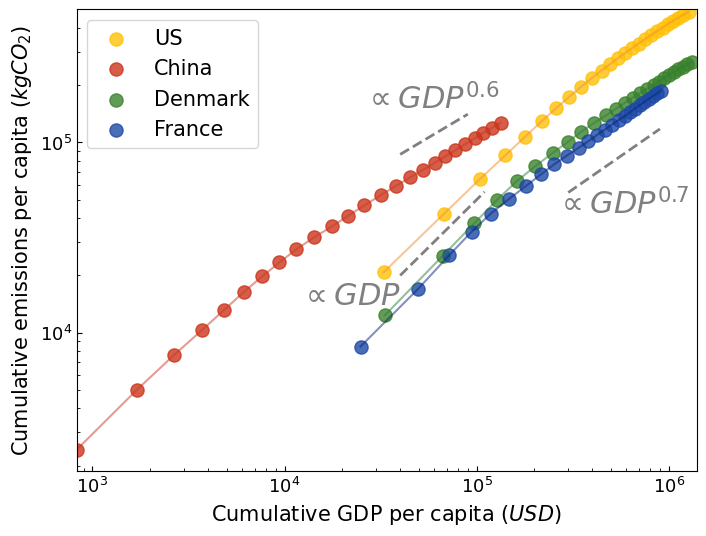

In [47]:
## Culative Emissions vs Cumulative GDP for all countries ##
countries = ['US', 'china', 'denmark', 'france']
duration = 25 #Duration in years
territorial = False #If True, use territorial emissions, else use consumption-based emissions
territorialstr = 'territorial' if territorial else 'consumption-based'

fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
clist = carr[:13].copy()
clist = [(0, clist[0]), (0.05, clist[1]), (0.1, clist[2]), (0.2, clist[3]), (0.32, clist[4]), (0.4, clist[5]), (0.5, clist[6]), (0.6, clist[7]), (0.65, clist[8]), (0.7, clist[9]), (0.75, clist[10]), (0.82, clist[11]), (1., clist[12])] #[(i*1/11., clist[i]) for i in range(len(clist))]
cmapphase = LinearSegmentedColormap.from_list('cmap', clist) #Create the colormap
for n, country in enumerate(countries):
    Emperyearlist = np.load(cd + '/data/Emperyearlist_'+country+'_'+territorialstr+'.npy') #Yearly emissions per capita data
    GDPpercapitalist = np.load(cd + '/data/GDPpercapita_'+country+'.npy') #GDP per capita data
    tflist=np.array(range(duration)) #Time frame list, from 0 to duration-1
    firstyear = 1960 + GDPpercapitalist.size-duration #Starting year for the study

    # Rescale all lists to have the same size
    Emperyearlist = Emperyearlist[-duration:]
    GDPpercapitalist = GDPpercapitalist[-duration:]
    cumEmissions = np.array([sum(Emperyearlist[:i+1]) for i in range(len(Emperyearlist))]) #Cumulative emissions list
    cumGDP = np.array([sum(GDPpercapitalist[:i+1]) for i in range(len(GDPpercapitalist))]) #Cumulative GDP list
    ax1.plot(cumGDP, cumEmissions, lw = 1.5, alpha = 0.5, ls='-', c=cmapphase(n/4+0.05)) #Plot data
    ax1.scatter(cumGDP, cumEmissions, marker = 'o', s=90, alpha = 0.8, c=cmapphase(n/4), label= 'US' if country == 'US' else str.upper(country[0]) + country[1:])

ax1.plot(np.logspace(np.log10(4E4),np.log10(1.1E5), 100), 0.5*np.logspace(np.log10(4E4),np.log10(1.1E5), 100), lw=2., ls='--', c='gray')
ax1.plot(np.logspace(np.log10(3E5),np.log10(9E5), 100), 8*np.logspace(np.log10(3E5),np.log10(9E5), 100)**0.7, lw=2., ls='--', c='gray')
ax1.plot(np.logspace(np.log10(4E4),np.log10(9E4), 100), 1.5E2*np.logspace(np.log10(4E4),np.log10(9E4), 100)**0.6, lw=2., ls='--', c='gray')

ax1.text(1.2E4, 1.4E4, r'$\propto GDP$', fontsize=22, color='gray')
ax1.text(2.6E5, 4.2E4, r'$\propto GDP^{0.7}$', fontsize=22, color='gray')
ax1.text(2.6E4, 1.5E5, r'$\propto GDP^{0.6}$', fontsize=22, color='gray')

ax1.legend(fontsize=15, loc='best')
ax1.set_xlabel(r'Cumulative GDP per capita ($USD$)', fontsize=15)
ax1.set_ylabel(r'Cumulative emissions per capita ($kgCO_2$)', fontsize=15)
ax1.margins(x=0)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlim(0,1.4E6)
ax1.set_ylim(0,5E5)
fig1.set_size_inches(8,6)
ax1.tick_params(direction='in', which='both', labelsize=13)
fig1.savefig(cd + '/results/cumEmissions_vs_cumGDP_all_'+territorialstr+'.pdf')

/var/folders/88/nhwhjjhs73j3_587yk930r480000gp/T/ipykernel_4766/2452114348.py:37: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax1.scatter(datax, datay, marker = 'o', s=100, alpha = 0.8, c=cmapphase(n/4))
/var/folders/88/nhwhjjhs73j3_587yk930r480000gp/T/ipykernel_4766/2452114348.py:40: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax2.scatter(datax, dataybis, marker = 'p', s=100, alpha = 0.7, c=cmapphase(n/4))


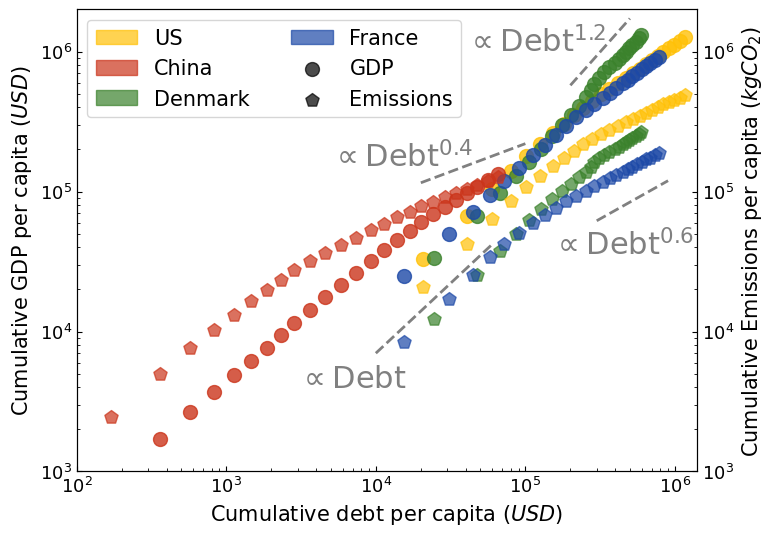

In [48]:
## Emissions vs Debt for all countries ##
countries = ['US', 'china', 'denmark', 'france']

xdata, ydata, ybisdata = 'debt', 'GDP', 'Em' #Pick the data to study among 'GDP', 'debt', 'deficit', 'Em'
cumu = True #True to study cumulative data, False for yearly data
logscale = True
doubleyaxis = True
territorial = False #If True, use territorial emissions, else use consumption-based emissions
territorialstr = 'territorial' if territorial else 'consumption-based'

duration = 25 #Duration in years
fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
if doubleyaxis:
    ax2 = ax1.twinx()
    ax2.yaxis.tick_right()
    ax2.yaxis.set_tick_params(direction='in', which='both')
clist = carr[:13].copy()
clist = [(0, clist[0]), (0.05, clist[1]), (0.1, clist[2]), (0.2, clist[3]), (0.32, clist[4]), (0.4, clist[5]), (0.5, clist[6]), (0.6, clist[7]), (0.65, clist[8]), (0.7, clist[9]), (0.75, clist[10]), (0.82, clist[11]), (1., clist[12])] #[(i*1/11., clist[i]) for i in range(len(clist))]
cmapphase = LinearSegmentedColormap.from_list('cmap', clist) #Create the colormap
for n, country in enumerate(countries):
    xperyear = np.load(cd + ('/data/'+xdata+'percapita_'+country+'.npy' if xdata != 'Em' else '/data/Emperyearlist_'+country+'_'+territorialstr+'.npy')) #x axis per year per capita data
    yperyear = np.load(cd + ('/data/'+ydata+'percapita_'+country+'.npy' if ydata != 'Em' else '/data/Emperyearlist_'+country+'_'+territorialstr+'.npy')) #y axis per year per capita data
    ybisperyear = np.load(cd + ('/data/'+ybisdata+'percapita_'+country+'.npy' if ybisdata != 'Em' else '/data/Emperyearlist_'+country+'_'+territorialstr+'.npy')) #y axis per year per capita data
    tflist=np.array(range(duration)) #Time frame list, from 0 to duration-1
    firstyear = 1960 + GDPpercapitalist.size-duration #Starting year for the study

    # Rescale all lists to have the same size
    xperyear = xperyear[-duration:]
    yperyear = yperyear[-duration:]
    ybisperyear = ybisperyear[-duration:]
    if cumu:
        datax = np.array([sum(xperyear[:i+1]) for i in range(len(xperyear))]) #x axis list
        datay = np.array([sum(yperyear[:i+1]) for i in range(len(yperyear))]) #y axis list
        dataybis = np.array([sum(ybisperyear[:i+1]) for i in range(len(ybisperyear))]) #y bis axis list
        #ax1.plot(datax, datay, lw = 1.5, alpha = 0.5, ls='-', c=cmapphase(n/4+0.05)) #Plot data
        ax1.scatter(datax, datay, marker = 'o', s=100, alpha = 0.8, c=cmapphase(n/4))
        if doubleyaxis:
            #ax2.plot(datax, dataybis, lw = 2.2, alpha = 0.7, ls='-', c=cmapphase(n/4+0.05)) #Plot data
            ax2.scatter(datax, dataybis, marker = 'p', s=100, alpha = 0.7, c=cmapphase(n/4))
    else:
        #ax1.plot(xperyear, yperyear, lw = 1.5, alpha = 0.5, ls='-', c=cmapphase(n/4+0.05)) #Plot data
        ax1.scatter(xperyear, yperyear, marker = 'o', s=100, alpha = 0.8, c=cmapphase(n/4))
        if doubleyaxis:
            #ax2.plot(xperyear, ybisperyear, lw = 2.2, alpha = 0.7, ls='-', c=cmapphase(n/4+0.05)) #Plot data
            ax2.scatter(xperyear, ybisperyear, marker = 'p', s=100, alpha = 0.7, c=cmapphase(n/4))

    ax1.fill_between([0,0], [0,0], [0,0], alpha = 0.7, color=cmapphase(n/4), label= 'US' if country == 'US' else str.upper(country[0]) + country[1:]) #Plot standard deviation
if doubleyaxis:
    ax1.scatter(0, 0, marker = 'o', s=100, alpha = 0.7, c='black', label = (ydata if ydata != 'Em' else 'Emissions'))
    ax1.scatter(0, 0, marker = 'p', s=100, alpha = 0.7, c='black', label = (ybisdata if ybisdata != 'Em' else 'Emissions'))

ax1.plot(np.logspace(np.log10(1E4),np.log10(6.E4), 100), 0.7*np.logspace(np.log10(1E4),np.log10(6.E4), 100), lw=2., ls='--', c='gray')
ax1.plot(np.logspace(np.log10(3E5),np.log10(9E5), 100), 3.2E1*np.logspace(np.log10(3E5),np.log10(9E5), 100)**0.6, lw=2., ls='--', c='gray')
ax1.plot(np.logspace(np.log10(2E4),np.log10(1E5), 100), 2.2E3*np.logspace(np.log10(2E4),np.log10(1E5), 100)**0.4, lw=2., ls='--', c='gray')
ax1.plot(np.logspace(np.log10(2E5),np.log10(5E5), 100), 0.25*np.logspace(np.log10(2E5),np.log10(5E5), 100)**1.2, lw=2., ls='--', c='gray')

ax1.text(3E3, 4E3, r'$\propto $' + str.upper(xdata[0]) + xdata[1:], fontsize=22, color='gray')
ax1.text(1.5E5, 3.5E4, r'$\propto$' + str.upper(xdata[0]) + xdata[1:] + r'$^{0.6}$', fontsize=22, color='gray')
ax1.text(5.E3, 1.5E5, r'$\propto$' + str.upper(xdata[0]) + xdata[1:] + r'$^{0.4}$', fontsize=22, color='gray')
ax1.text(4.E4, 1.E6, r'$\propto$' + str.upper(xdata[0]) + xdata[1:] + r'$^{1.2}$', fontsize=22, color='gray')

if cumu:
    ax1.set_xlabel(r'Cumulative '+(xdata if xdata != 'Em' else 'Emissions')+r' per capita ' + (r'($USD$)' if xdata != 'Em' else r'($kgCO_2$)'), fontsize=15) #($USD$), ($kgCO_2$)
    ax1.set_ylabel(r'Cumulative '+(ydata if ydata != 'Em' else 'Emissions')+r' per capita ' + (r'($USD$)' if ydata != 'Em' else r'($kgCO_2$)'), fontsize=15) #($USD$), ($kgCO_2$)
    if doubleyaxis:
        ax2.set_ylabel(r'Cumulative '+(ybisdata if ybisdata != 'Em' else 'Emissions')+r' per capita ' + (r'($USD$)' if ybisdata != 'Em' else r'($kgCO_2$)'), fontsize=15)
else:
    ax1.set_xlabel((xdata if xdata != 'Em' else 'Emissions')+r' per capita ' + (r'($USD$)' if xdata != 'Em' else r'($kgCO_2$)'), fontsize=15) #($USD$), ($kgCO_2$)
    ax1.set_ylabel((ydata if ydata != 'Em' else 'Emissions')+r' per capita ' + (r'($USD$)' if ydata != 'Em' else r'($kgCO_2$)'), fontsize=15) #($USD$), ($kgCO_2$)
    if doubleyaxis:
        ax2.set_ylabel((ybisdata if ybisdata != 'Em' else 'Emissions')+r' per capita ' + (r'($USD$)' if ybisdata != 'Em' else r'($kgCO_2$)'), fontsize=15)
ax1.margins(x=0)
if logscale:
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax2.set_xscale('log')
    ax2.set_yscale('log')
ax1.set_xlim(1E2,1.4E6)
ax1.set_ylim(1E3,2E6)
ax2.set_ylim(1E3,2E6)
fig1.set_size_inches(8,6)
ax1.tick_params(direction='in', which='both', labelsize=13)
ax2.tick_params(direction='in', which='both', labelsize=13)
ax1.legend(fontsize=15, loc='best', ncol=2 if doubleyaxis else 1)
fig1.savefig(cd + '/results/cum'+ydata+'_cum'+ybisdata+'_vs_cum'+xdata+'_all_'+territorialstr+'.pdf')